# Project Description

The telecom operator Interconnect would like to be able to forecast their churn of clients. 
- If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. 

Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

Interconnect mainly provides two types of services:
- Landline communication: The telephone can be connected to several lines simultaneously.
- Internet: The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.


Some other services the company provides include:
- Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
- A dedicated technical support line (TechSupport)
- Cloud file storage and data backup (OnlineBackup)
- TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose a month-to-month, 1-year, or 2-year contract. 

They can use various payment methods and receive an electronic invoice after a transaction.

# Project Process Overview

1. Load, preview, and clean each dataset.
2. Explore the distribution of features in each dataset and engineer new features.
3. Merge the dataset DataFrames into a single Dataframe for additional exploratory data analaysis.
4. Pre-process the data for model training including encoding categorical data, scaling numerical features (for features that don't already have binary values), specifying the features and target, and splitting the DataFrame into training, validation, and testing sets.
5. Scale numerical features (for features that don't already have binary values).
6. Specify the features and target for model training.
7. Split the DataFrame into training, validation, and testing sets.
8. Hypertune and train the model on various classifier models including LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, and/or LGBMClassifier.
9. Account for class imbalance in the target.
10. Get the AUC-ROC value and accuracy score for each model for the validation set. 
11. Take the model with the best score and get the AUC-ROC value and accuracy score for the testing set.
12. Make adjustments as necessary to improve the score to the project threshold of an AUC-ROC value above 0.75, but aim to achieve the highest criteria tier value (an AUC-ROC score >= 0.85).
    - Adjustments could include handling the class imbalance in different ways and engineering additional features.
13. Make conclusions about the model performance and what it means for Interconnect's business. 
14. Make recommendations for Interconnect to reduce customer churn.

# Data Overview

The data consists of files obtained from different sources:
- contract.csv — contract information
- personal.csv — the client's personal data
- internet.csv — information about Internet services
- phone.csv — information about telephone services

In each file, the column customerID contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.


## Assessment Criteria

- Primary metric: AUC-ROC
- Additional metric: Accuracy
- Assessment criteria:
    - AUC-ROC < 0.75 — 0 Story Points
    - 0.75 ≤ AUC-ROC < 0.81 — 4 Story Points
    - 0.81 ≤ AUC-ROC < 0.85 — 4.5 Story Points
    - 0.85 ≤ AUC-ROC < 0.87 — 5 Story Points
    - 0.87 ≤ AUC-ROC < 0.88 — 5.5 Story Points
    - AUC-ROC ≥ 0.88 — 6 Story Points

<i> Story points reflect the difficulty of the task with 6 points representing the highest level of difficulty. </i>

## Initialization 

In [1]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# EDA

## Contract Dataset

### Load and Preview Data

In [2]:
# read contract.csv into a DataFrame
contract = pd.read_csv('contract.csv')

# rename the columns
contract.columns = ['CustomerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

# preview the first 5 rows of the DataFrame
print(contract.head(),'\n')

# get information about the contract DataFrame
contract.info()

# describe contract including all columns
print('\n Describe contract:',contract.describe(include='all'))


# count duplicate rows
print('\n Number of duplicate rows:',contract.duplicated().sum())

   CustomerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null C

A few initial observations about the contract DataFrame:
- There aren't any obvious null values.
- Our target column, EndDate, is not a boolean column, but instead 'No' where there isn't an end date and a specific date when there is an end date. 
- We need to convert our BeginDate and EndDate columns into datetime columns and our TotalCharges column into a float data type. 
- TotalCharges did not display as expected when described so we'll have to investigate what values led pandas to read the column as an object in the first place.
- PaperlessBilling yes/no values can be turned into binary values instead for better compatibility with our model down the line.

### Explore Data

In [3]:
# get the value counts of TotalCharges
contract['TotalCharges'].value_counts()

TotalCharges
          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: count, Length: 6531, dtype: int64

Since just 11 rows of the TotalCharges column are NaN, we'll drop them.

In [4]:
# drop rows in TotalCharges that are ' '
contract = contract[contract['TotalCharges'] != ' ']

# convert TotalCharges to float
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

# describe TotalCharges
print('\n Describe TotalCharges:',contract['TotalCharges'].describe())


 Describe TotalCharges: count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


In [5]:
# verify is totalcharges reflects charges paid thus far or expected charges for the contract length
verify = contract[(contract['Type'] == 'One year') & (contract['BeginDate'] >= '2020-01-01')][['TotalCharges', 'MonthlyCharges', 'BeginDate']]
print(verify)

      TotalCharges  MonthlyCharges   BeginDate
222          20.20           20.20  2020-01-01
1168         19.65           19.65  2020-01-01
1286         74.10           74.10  2020-01-01
1654         18.80           18.80  2020-01-01
2993         20.40           20.40  2020-01-01
4767         19.85           19.85  2020-01-01
6149         25.85           25.85  2020-01-01


It looks like the TotalCharges column reflects the amount that the customer has paid to date in their time as an Interconnect customer.

In [6]:
# create a binary column indicating if the contract is still active
contract['EndDate_Binary'] = contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [7]:
# convert EndDate and BeginDate to datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

# for contracts that are still active, replace the EndDate with 2020-02-01 and store in a new column
contract['EndDate_Calc'] = contract['EndDate'].fillna(pd.to_datetime('2020-02-01'))

# calculate the length of time the customer has been with the company in months
contract['CustomerTenure_Months'] = (contract['EndDate_Calc'].dt.year - contract['BeginDate'].dt.year) * 12 + (contract['EndDate_Calc'].dt.month - contract['BeginDate'].dt.month)

# calculate the avg. monthly charge as the totalcharges paid by the customer divided by the tenure in months
contract['Avg_MonthlyCharge'] = contract['TotalCharges'] / contract['CustomerTenure_Months']

# create a new column for the year the contract started
contract['BeginDate_Year'] = contract['BeginDate'].dt.year

# turn PaperlessBilling into a binary column - 1 for Yes, 0 for No
contract['PaperlessBilling'] = contract['PaperlessBilling'].apply(lambda x: 1 if x == 'Yes' else 0)

# create new columns to assess charges in excess of the expected amount given the customer tenure in months and the monthly charge rate (one column each for the adjustment amount, overage amount, discount amount plus two others to indicate if there was overage or discount)
contract['Price_Adjustments_From_Current_Monthly_Charge'] = contract['TotalCharges'] - contract['MonthlyCharges'] * contract['CustomerTenure_Months'].round(2)
contract['Price_Adjustments_Above_Current_Monthly_Charge'] = contract['Price_Adjustments_From_Current_Monthly_Charge'].apply(lambda x: 0 if x <= 0.00 else x)
contract['Price_Adjustments_Below_Current_Monthly_Charge'] = contract['Price_Adjustments_From_Current_Monthly_Charge'].apply(lambda x: 0 if x >= 0.00 else x)
contract['Has_Overage_or_Increase_Charges'] = contract['Price_Adjustments_From_Current_Monthly_Charge'].apply(lambda x: 1 if x > 0.00 else 0)
contract['Has_Discount_or_Decrease_Charges'] = contract['Price_Adjustments_From_Current_Monthly_Charge'].apply(lambda x: 1 if x < 0.00 else 0)


/var/folders/6k/r1zgzskx1kd7_3xy_n5q44rm0000gn/T/ipykernel_20214/818859245.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')


In [8]:
# count rows where the contract begin date is after Feb 1, 2020
contract[contract['BeginDate'] > '2020-02-01'].shape[0]


0

The contract data is valid as of Feb 1, 2020 and there aren't any contract BeginDate values after this date so the contract data should be valid.

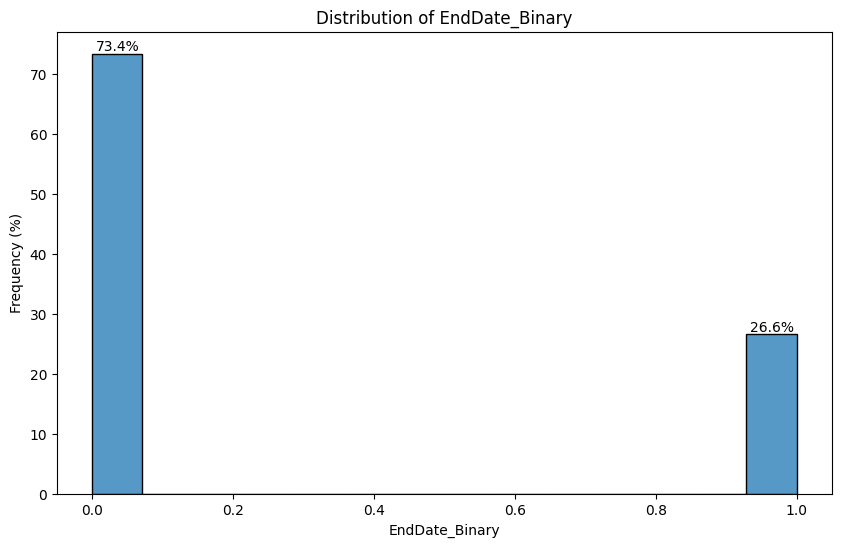

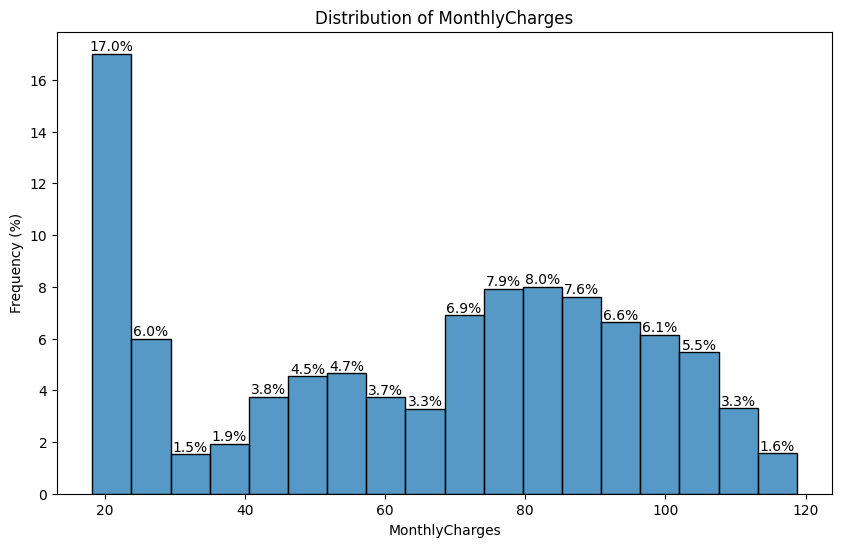

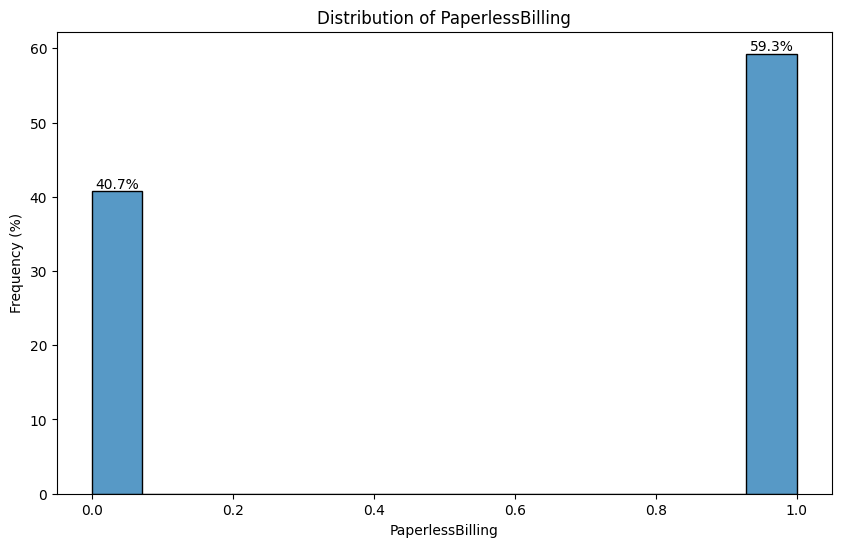

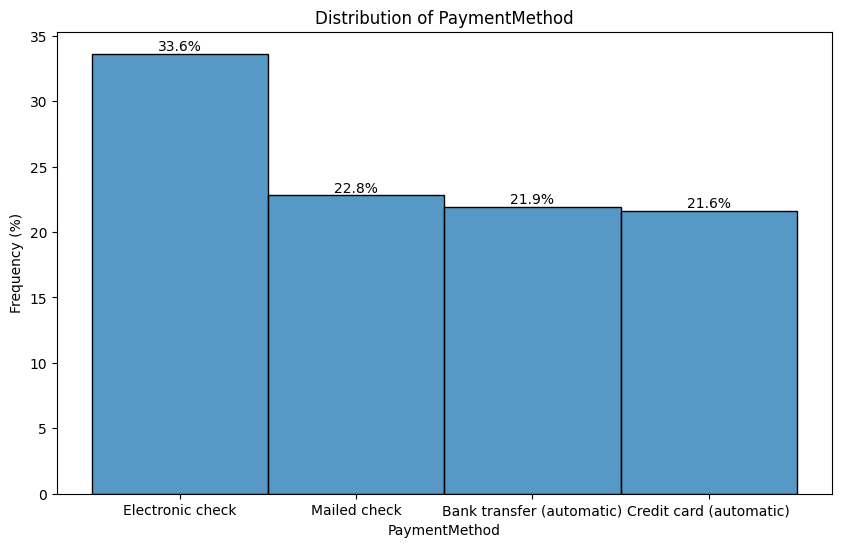

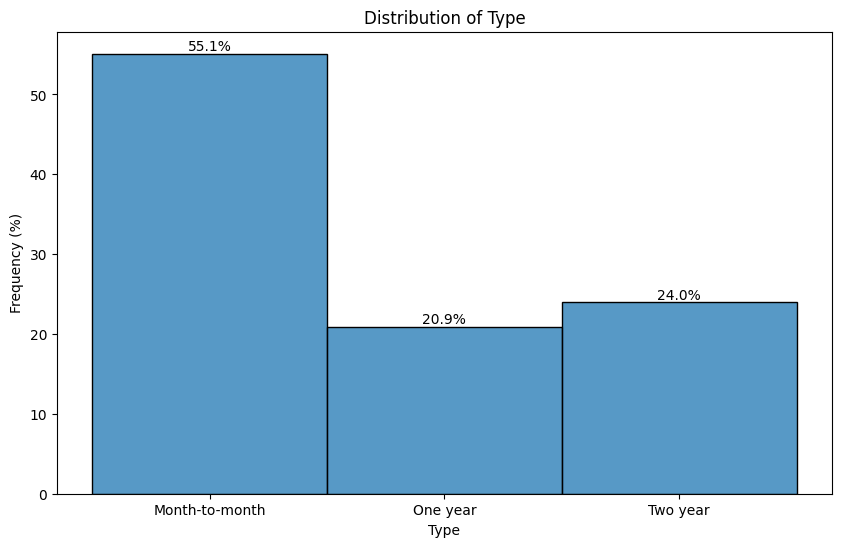

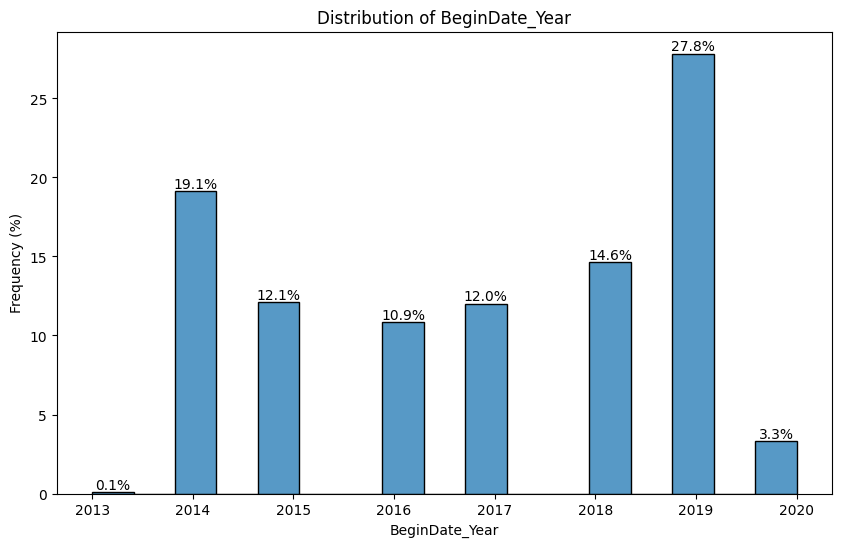

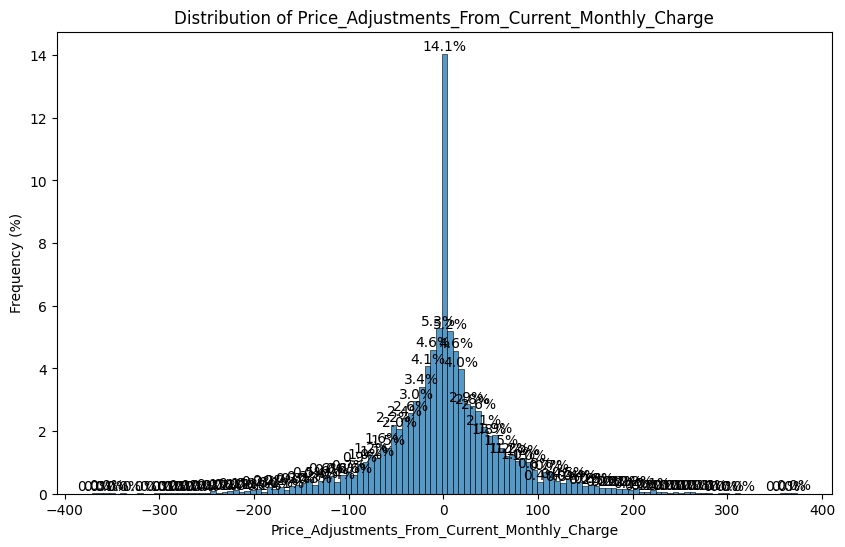

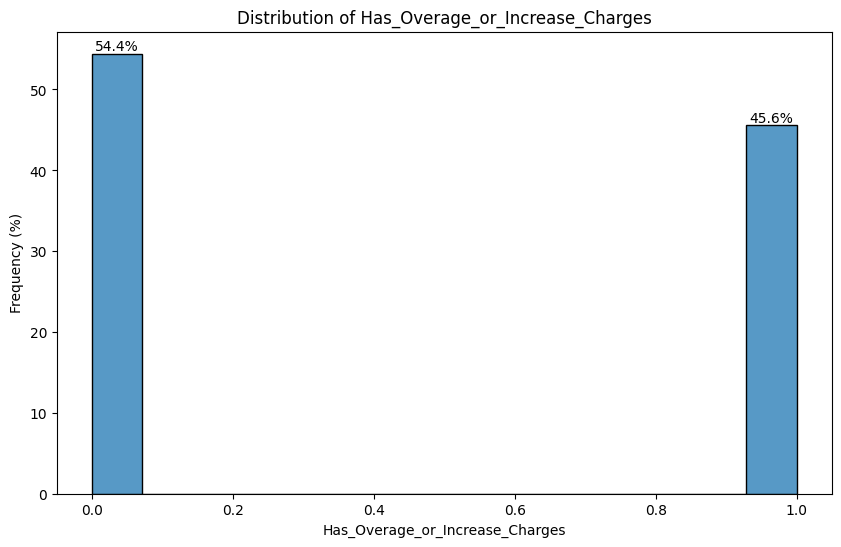

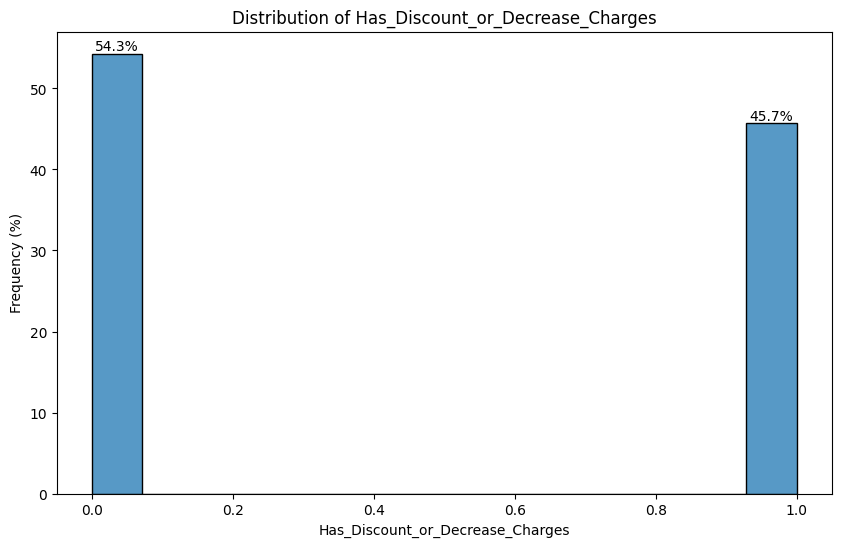

In [9]:
contract_cols = ['EndDate_Binary', 'MonthlyCharges', 'PaperlessBilling', 'PaymentMethod', 'Type', 'BeginDate_Year', 'Price_Adjustments_From_Current_Monthly_Charge', 'Has_Overage_or_Increase_Charges','Has_Discount_or_Decrease_Charges']

# for each column in contract_cols, plot the distribution of the column
for col in contract_cols:
    plt.figure(figsize=(10, 6))
    
    # create the histogram
    ax = sns.histplot(x=col, data=contract, stat='percent')
    
    # Add percentage labels to each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only add labels to non-zero bars
            ax.annotate(f'{height:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=10)
            
    plt.title('Distribution of ' + col)
    plt.xlabel(col)
    plt.ylabel('Frequency (%)')
    plt.show()

45.7% of customers have a discount/price decrease from a previous monthly charge rate and 45.6% of customers have an overage charge/price increase from a previous monthly charge rate. 

We don't know if Interconnect has changed their monthly rates per plan over time or if they offer discounts/charge overage fees. However, we we know each customer's monthly rate, how long they have been a customer, and how much they have paid Interconnect in their total time as a customer, so we can deduce that customers are paying both more than and less than the total we would expect them to pay based on their given monthly rate and tenure.

Let's dig into how these overage charges/price increases and discounts/price decreases have evolved over time.

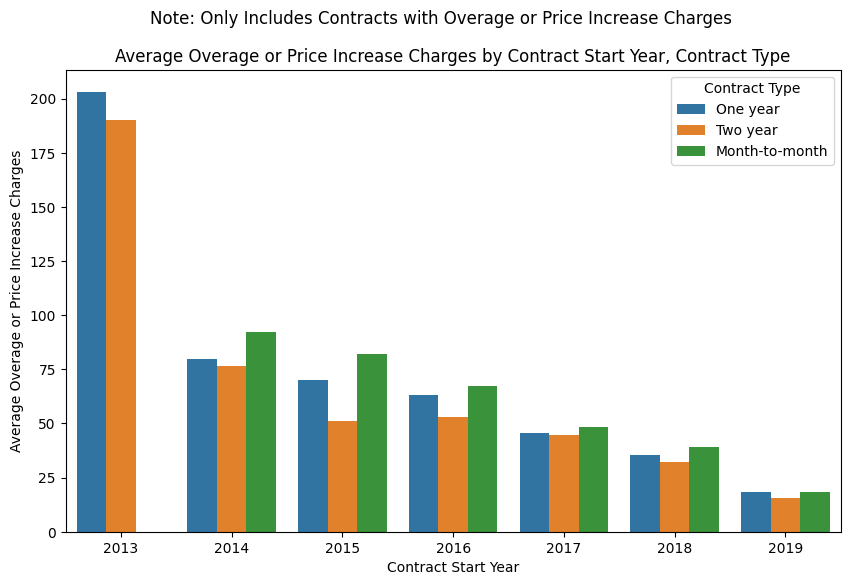

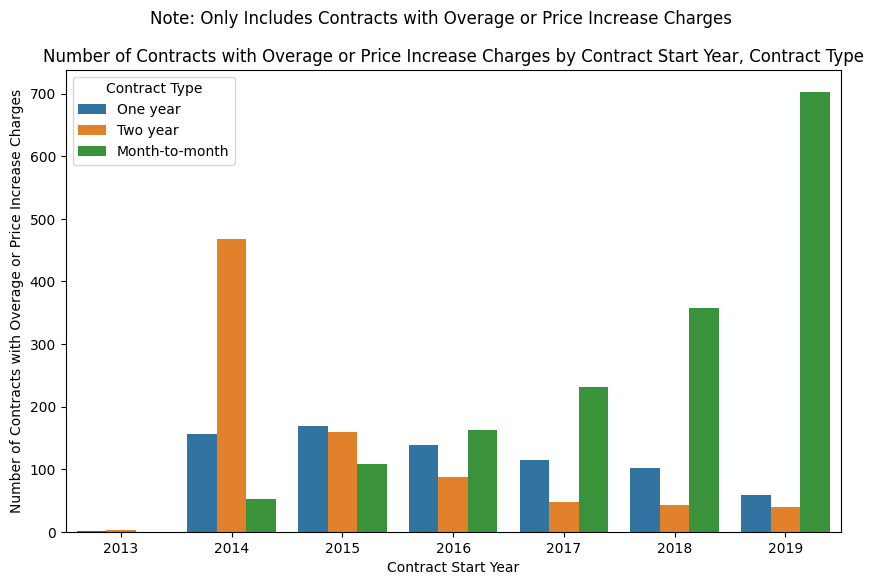

In [10]:
# filter the contract DataFrame to only include contracts with overage or price increase charges
contracts_with_overage = contract[contract['Has_Overage_or_Increase_Charges'] == 1]

# group the contracts with overage charges by contract type and contract start year
contract_overages_by_type_beginyear = contracts_with_overage.groupby(['Type', 'BeginDate_Year']).agg({'Price_Adjustments_From_Current_Monthly_Charge': ['sum','mean'], 'Has_Overage_or_Increase_Charges': 'sum'}).reset_index()

# plot the average overage charges by Contract Start Year, contract type
plt.figure(figsize=(10, 6))
sns.barplot(x='BeginDate_Year', y=('Price_Adjustments_From_Current_Monthly_Charge', 'mean'), hue='Type', data=contract_overages_by_type_beginyear)
plt.suptitle('Note: Only Includes Contracts with Overage or Price Increase Charges')
plt.title('Average Overage or Price Increase Charges by Contract Start Year, Contract Type')
plt.xlabel('Contract Start Year')
plt.ylabel('Average Overage or Price Increase Charges')
plt.legend(title='Contract Type')
plt.show()

# plot the number of contracts with overage charges by contract type
plt.figure(figsize=(10, 6))
sns.barplot(x='BeginDate_Year', y=('Has_Overage_or_Increase_Charges', 'sum'), hue='Type', data=contract_overages_by_type_beginyear)
plt.title('Number of Contracts with Overage or Price Increase Charges by Contract Start Year, Contract Type')
plt.suptitle('Note: Only Includes Contracts with Overage or Price Increase Charges')
plt.xlabel('Contract Start Year')
plt.ylabel('Number of Contracts with Overage or Price Increase Charges')
plt.legend(title='Contract Type')
plt.show()

It's clear that average overage charge/price rate increase amount has declined overtime but the number of month-to-month plan type customers with these charges above their current monthly rate have increased drastically over time--especially from 2018 to 2019!

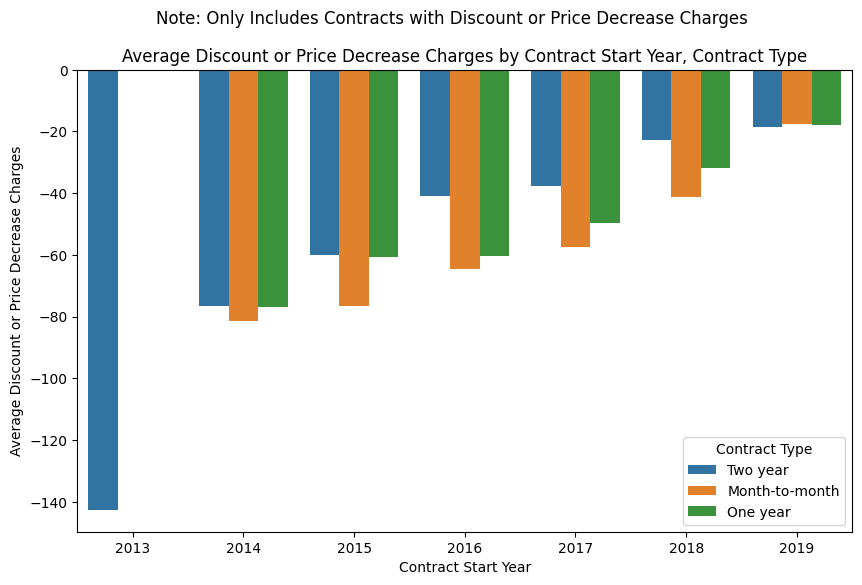

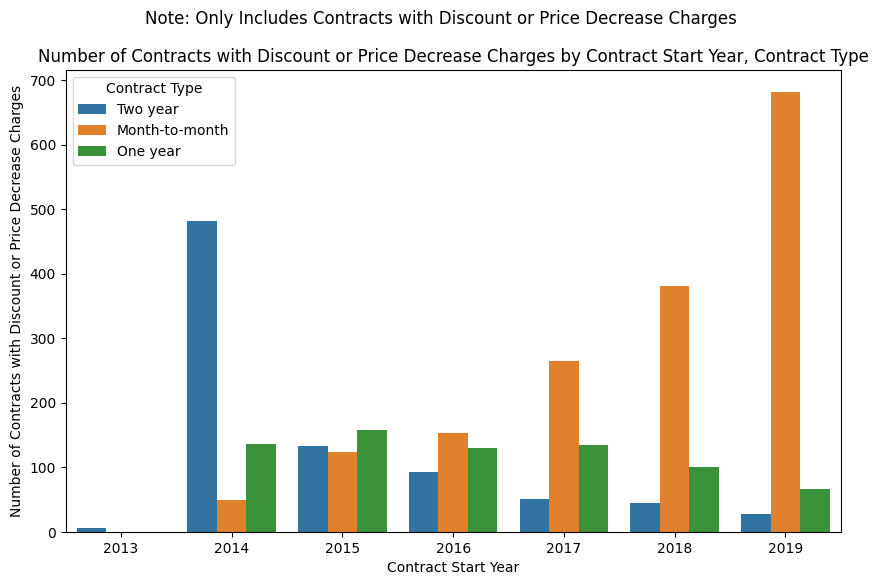

In [11]:
# filter the contract DataFrame to only include contracts with discount or price decrease charges
contracts_with_discounts = contract[contract['Has_Discount_or_Decrease_Charges'] == 1]

# group the contracts with discount charges by contract type and contract start year
contracts_with_discounts_by_type_beginyear = contracts_with_discounts.groupby(['Type', 'BeginDate_Year']).agg({'Price_Adjustments_From_Current_Monthly_Charge': ['sum','mean'], 'Has_Discount_or_Decrease_Charges': 'sum'}).reset_index()

# plot the average overage charges by Contract Start Year, contract type
plt.figure(figsize=(10, 6))
sns.barplot(x='BeginDate_Year', y=('Price_Adjustments_From_Current_Monthly_Charge', 'mean'), hue='Type', data=contracts_with_discounts_by_type_beginyear)
plt.suptitle('Note: Only Includes Contracts with Discount or Price Decrease Charges')
plt.title('Average Discount or Price Decrease Charges by Contract Start Year, Contract Type')
plt.xlabel('Contract Start Year')
plt.ylabel('Average Discount or Price Decrease Charges')
plt.legend(title='Contract Type')
plt.show()

# plot the number of contracts with overage charges by contract type
plt.figure(figsize=(10, 6))
sns.barplot(x='BeginDate_Year', y=('Has_Discount_or_Decrease_Charges', 'sum'), hue='Type', data=contracts_with_discounts_by_type_beginyear)
plt.title('Number of Contracts with Discount or Price Decrease Charges by Contract Start Year, Contract Type')
plt.suptitle('Note: Only Includes Contracts with Discount or Price Decrease Charges')
plt.xlabel('Contract Start Year')
plt.ylabel('Number of Contracts with Discount or Price Decrease Charges')
plt.legend(title='Contract Type')
plt.show()

Similar, the avg. discount or price rate decrease amount has decreased over time while while the number of month-to-month plan type customers with a discount or price decrease from their monthly rate have shot up over time--again, quite drastically from 2018 to 2019.

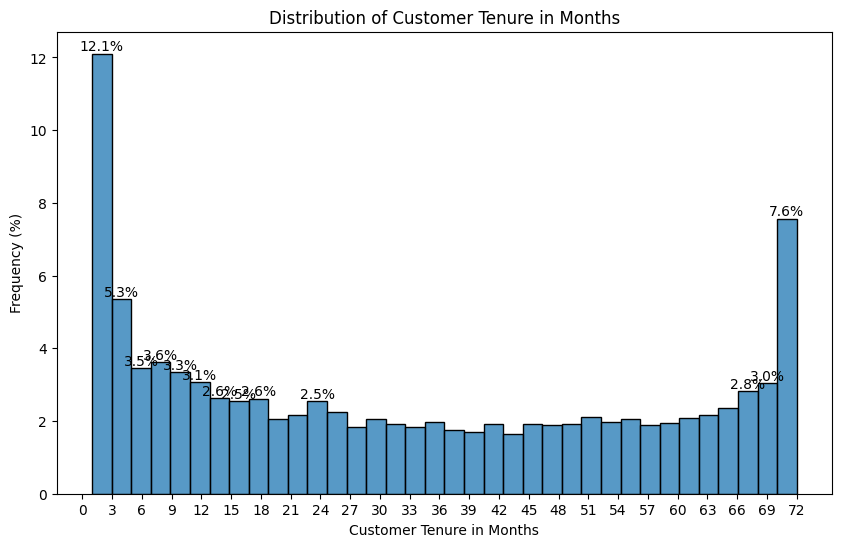

In [12]:
# plot the distribution of customer tenure in months separately to better visualize the distribution
plt.figure(figsize=(10, 6))

# create the histogram
ax = sns.histplot(x='CustomerTenure_Months', data=contract, stat='percent', bins=36)

# add percentage labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 2.5:  # only add labels to bars above 2.5%
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Customer Tenure in Months')
plt.xlabel('Customer Tenure in Months')
plt.ylabel('Frequency (%)')
plt.xticks(np.arange(0, 73, 3)) # plot labels for every 3 months
plt.show()

In [13]:
# describe the customer tenure in months
contract['CustomerTenure_Months'].describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: CustomerTenure_Months, dtype: float64

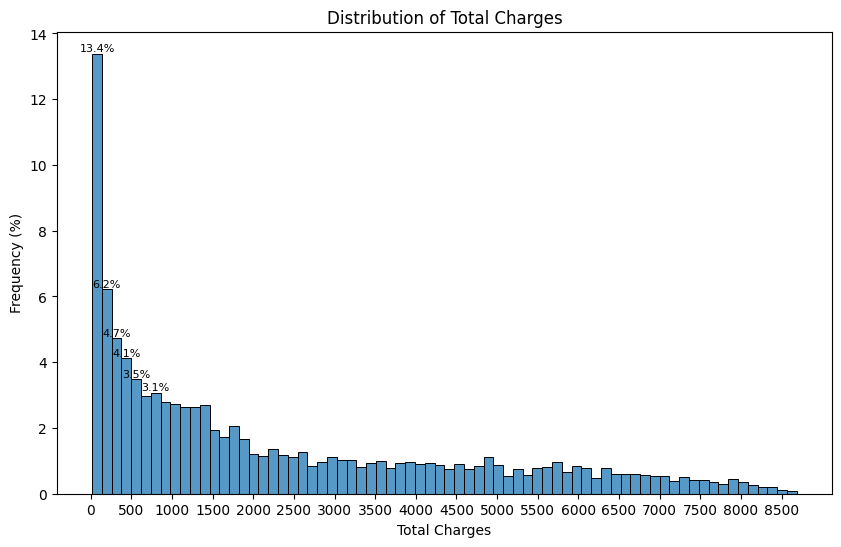

In [14]:
# plot the distribution of TotalCharges separately to better visualize the distribution bins
plt.figure(figsize=(10, 6))

# create the histogram
ax = sns.histplot(x='TotalCharges', data=contract, stat='percent', bins=72)

# add percentage labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 3:  # Only add labels to bars above 3%
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=8)

plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency (%)')
plt.xticks(np.arange(0, 9000, 500)) # plot labels for every 500
plt.show()

In [15]:
# create a new column indicating if the payment method is automatic or not
contract['Is_Automatic_Payment'] = contract['PaymentMethod'].apply(lambda x: 1 if x == 'Bank transfers (automatic)' or x == 'Credit card (automatic)' else 0)

### Initial Takeaways about the Contract Data

- The target class (EndDate_Binary) is imbalanced: 73.5% of contracts don't have an end date while 26.5% do. We can address this imbalance later in our model if necessary.
- The monthly charge is slightly left-skewed with a mean of 64.76 and a median of 70.35 while total charges are right-skewed with a mean of 2283.30 and a median of 1397.47. 
- A majority of contracts (59.3%) have opted into paperless billing. 
- The distribution of payment method is more varied; 33.6% of customers pay via electronic check while about 22% respectively mail in their check, use automatic bank transfers, or automatically pay via credit card. 
    - That means 43.5% pay automatically while 56.5% pay manually—a binary feature was engineered to capture manual vs. automatic payment, which could be a useful model input.
- 55.1% of customers are on a month-to-month contract, 20.9% are on a one year contract, and 24.0% are on a two year contract.
- Given that this data is valid as of February 1, 2020, around 30% of customers began their contract in the past year (from Feb 1, 2020). 
    - We can assume the company started in 2013—the year in which 0.1% of contracts began. 
    - Otherwise, the distribution of contracts are fairly dispersed by their beginning year between 2014 and 2018—the frequencies (in percentiles) range from 10.9% to 19.1%.
- The customer tenure (length of time the customer has been with the company as of February 1, 2020) is just slightly right-skewed with a mean of 32.4 months and a median of 29.0 months. 
    - 12.1% of customers have been (or were only ever) Interconnect customers for 3 or less months while 7.6% have been customers for around 70-72 months (6 years!).
- A high majority of customers have total charges that exceed or fall below the expected total based on their current monthly rate and tenure as Interconnect customers (in months). 
    - The average overage amount/potential price increase has been declining over time for all plan types but the total number of customers in this bucket has increased sharply over time--especially in 2019.
    - The average discount amount/potential price decrease has been declining over time for all plan types as well but the total number of customers in this bucket has also increased sharply over time--especially in 2019.

## Personal Data

### Load and Preview Data

In [16]:
# read personal.csv into a DataFrame
personal = pd.read_csv('personal.csv')

# rename the columns
personal.columns = ['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents']

# preview the 5 random rows of the DataFrame
print(personal.sample(5),'\n')

# get information about the personal DataFrame
personal.info()

# describe personal including all columns
print('\n Describe personal:',personal.describe(include='all'))

# count duplicate rows
print('\n Number of duplicate rows:',personal.duplicated().sum())

      CustomerID  Gender  SeniorCitizen Partner Dependents
2994  8046-DNVTL    Male              0     Yes         No
3187  7682-AZNDK    Male              0     Yes        Yes
2591  8384-FZBJK  Female              0     Yes        Yes
4475  4693-VWVBO  Female              0      No         No
5511  6586-MYGKD    Male              0     Yes         No 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

 Describe personal:         CustomerID Gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN    

A few initial observations about the personal dataset:
- There aren't any obvious missing values or duplicate rows in the personal dataset.
- SeniorCitizen is a binary column, but the Partner and Dependent columns, which have yes/no values, should also be binary values for the eventual model training step.

### Explore Data

In [17]:
# convert Partner into a binary column - 1 for Yes, 0 for No
personal['Partner'] = personal['Partner'].apply(lambda x: 1 if x == 'Yes' else 0)

# convert Dependents into a binary column - 1 for Yes, 0 for No
personal['Dependents'] = personal['Dependents'].apply(lambda x: 1 if x == 'Yes' else 0)

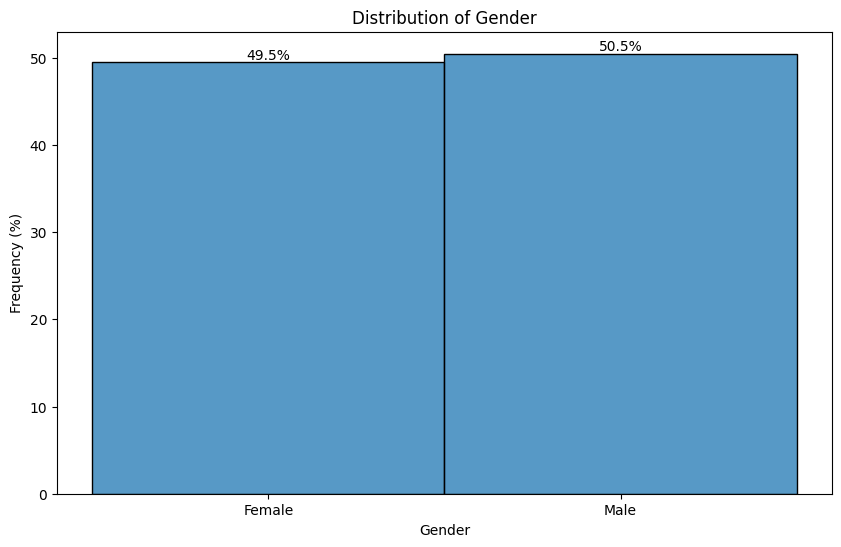

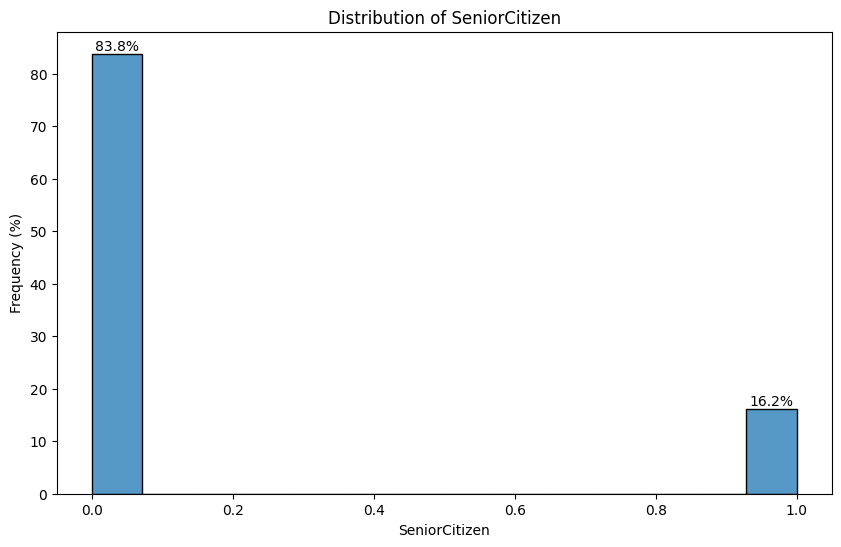

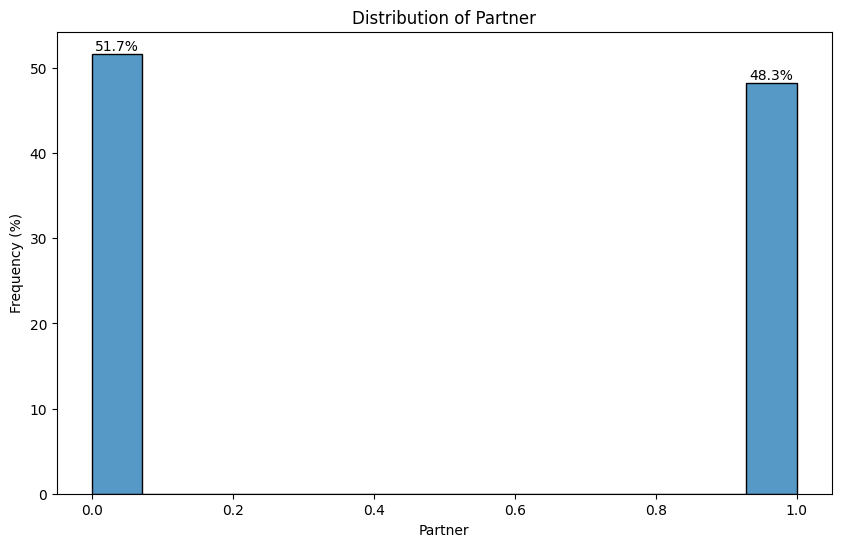

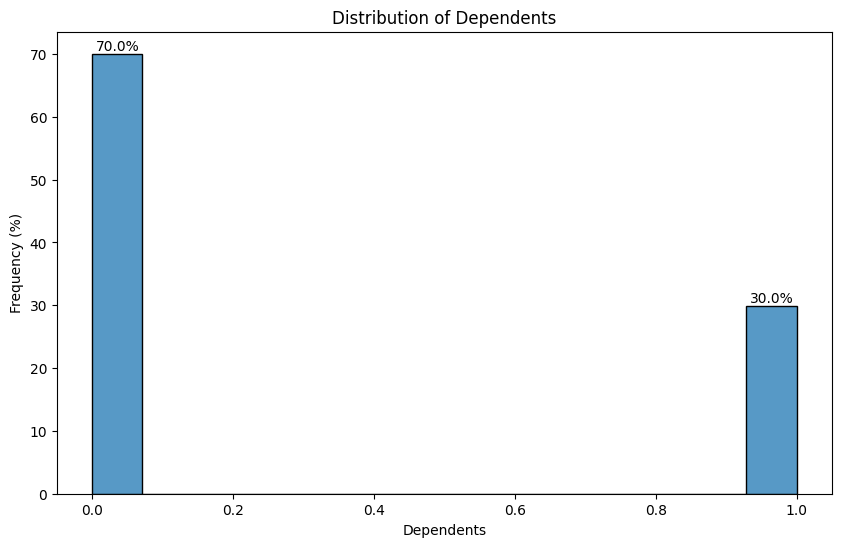

In [18]:
# specify the columns to plot
personal_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents']

# for each column in contract_cols, plot the distribution of the column
for col in personal_cols:
    plt.figure(figsize=(10, 6))
    
    # create the histogram
    ax = sns.histplot(x=col, data=personal, stat='percent')
    
    # Add percentage labels to each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only add labels to non-zero bars
            ax.annotate(f'{height:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=10)
            
    plt.title('Distribution of ' + col)
    plt.xlabel(col)
    plt.ylabel('Frequency (%)')
    plt.show()

### Initial Takeaways about the Personal Data

- The gender of the customers is almost equal at 49.5% female customers and 50.5% male customers. 
- Similarly, 51.7% of customers don’t have a partner while 48.3% do. 
- The distribution of the senior citizen and dependents data is less even:
    - Only 16.2% of customers are senior citizens and 30% of customers have dependents.

## Phone Dataset

### Load and Preview Data

In [19]:
# read phone.csv into a DataFrame
phone = pd.read_csv('phone.csv')

# rename the columns
phone.columns = ['CustomerID', 'MultipleLines']

# preview the first 5 rows of the DataFrame
print(phone.head(),'\n')

# get information about the phone DataFrame
phone.info()

# describe phone including all columns
print('\n Describe phone:',phone.describe(include='all'))

# count duplicate rows
print('\n Number of duplicate rows:',phone.duplicated().sum())

   CustomerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

 Describe phone:         CustomerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

 Number of duplicate rows: 0


A few initial observations about the phone dataset:

- There are only two columns in the phone dataset and neither have any missing values or obvious duplicate rows. 
- MultipleLines has yes/no values, but binary values would be better suited for eventual model training.

### Explore Data

In [20]:
# convert MultipleLines into a binary column - 1 for Yes, 0 for No
phone['MultipleLines'] = phone['MultipleLines'].apply(lambda x: 1 if x == 'Yes' else 0)

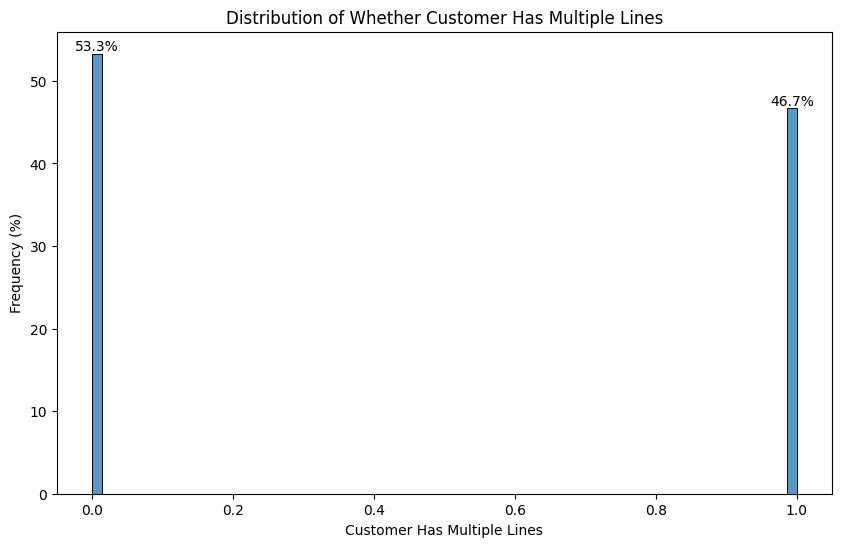

In [21]:
# plot the distribution of MultipleLines 
plt.figure(figsize=(10, 6))

# create the histogram
ax = sns.histplot(x='MultipleLines', data=phone, stat='percent', bins=72)

# add percentage labels to each bar
for p in ax.patches:
    height = p.get_height()
    if height > 1.5:  # Only add labels to bars above 1.5%
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Whether Customer Has Multiple Lines')
plt.xlabel('Customer Has Multiple Lines')
plt.ylabel('Frequency (%)')
plt.show()

Slightly more customers have a single phone line at 53.3% while 46.7% have multiple lines.

## Internet Dataset

### Load and Preview Data

In [22]:
# read internet.csv into a DataFrame
internet = pd.read_csv('internet.csv')

# rename the columns
internet.columns = ['CustomerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# preview the first 5 rows of the DataFrame
print(internet.head(),'\n')

# get information about the internet DataFrame
internet.info()

# describe internet including all columns
print('\n Describe internet:', internet.describe(include='all'))

# count duplicate rows
print('\n Number of duplicate rows:', internet.duplicated().sum())

   CustomerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        5517 non-null   object
 1   InternetService 

A few initial observations about the internet dataset:
- No columns have any obvious missing values or duplicate rows.
- Beside CustomerID and InternetService, all other columns have yes/no values. It will be better for eventual model training to turn them into binary values instead.

### Explore Data

In [23]:
# convert OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies into binary columns - 1 for Yes, 0 for No
internet['OnlineSecurity'] = internet['OnlineSecurity'].apply(lambda x: 1 if x == 'Yes' else 0)
internet['OnlineBackup'] = internet['OnlineBackup'].apply(lambda x: 1 if x == 'Yes' else 0)
internet['DeviceProtection'] = internet['DeviceProtection'].apply(lambda x: 1 if x == 'Yes' else 0)
internet['TechSupport'] = internet['TechSupport'].apply(lambda x: 1 if x == 'Yes' else 0)
internet['StreamingTV'] = internet['StreamingTV'].apply(lambda x: 1 if x == 'Yes' else 0)
internet['StreamingMovies'] = internet['StreamingMovies'].apply(lambda x: 1 if x == 'Yes' else 0)

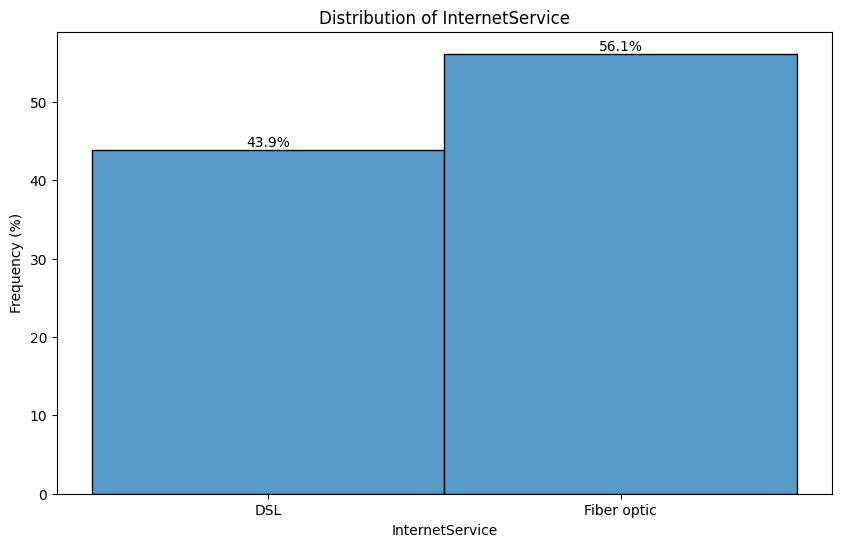

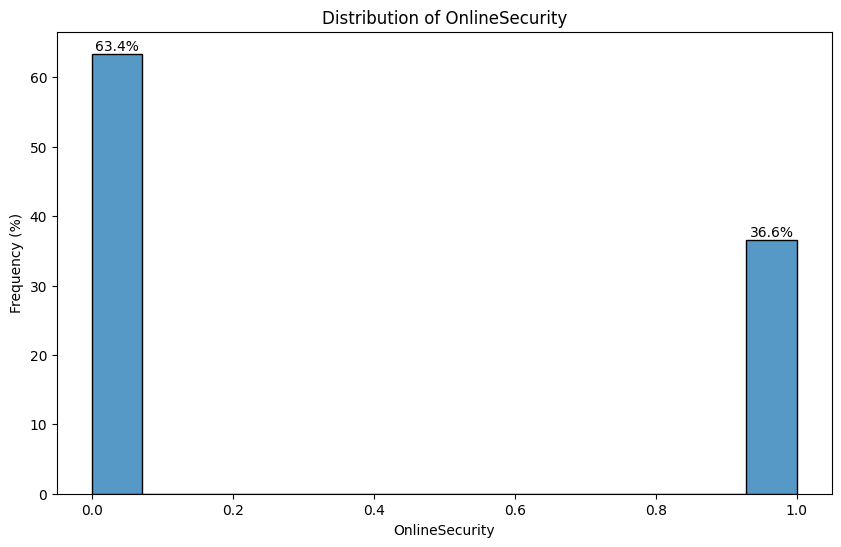

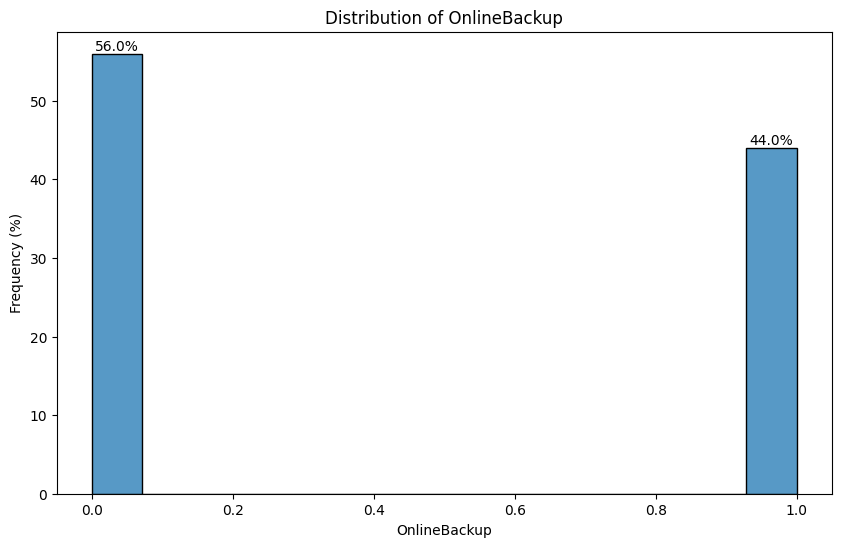

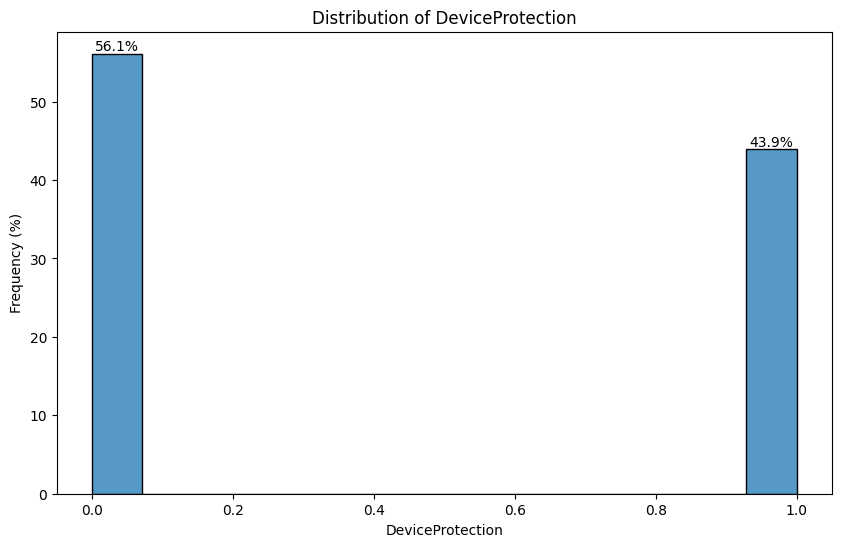

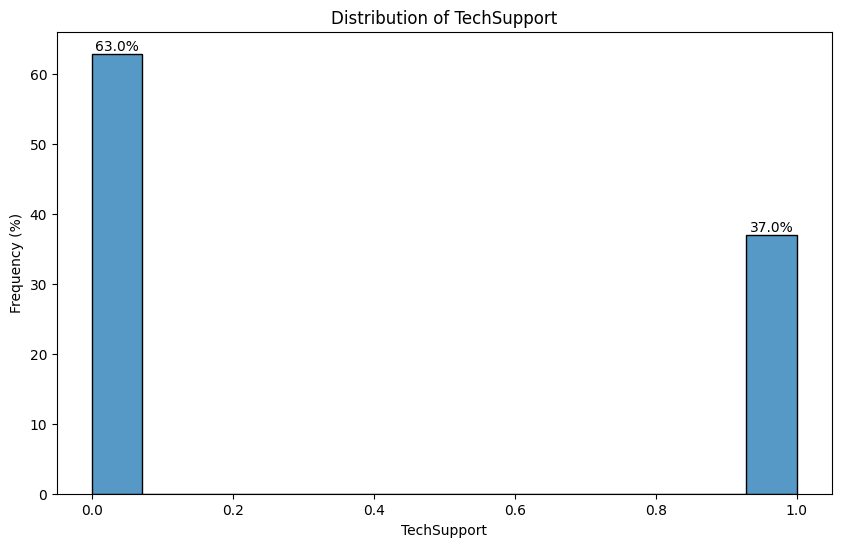

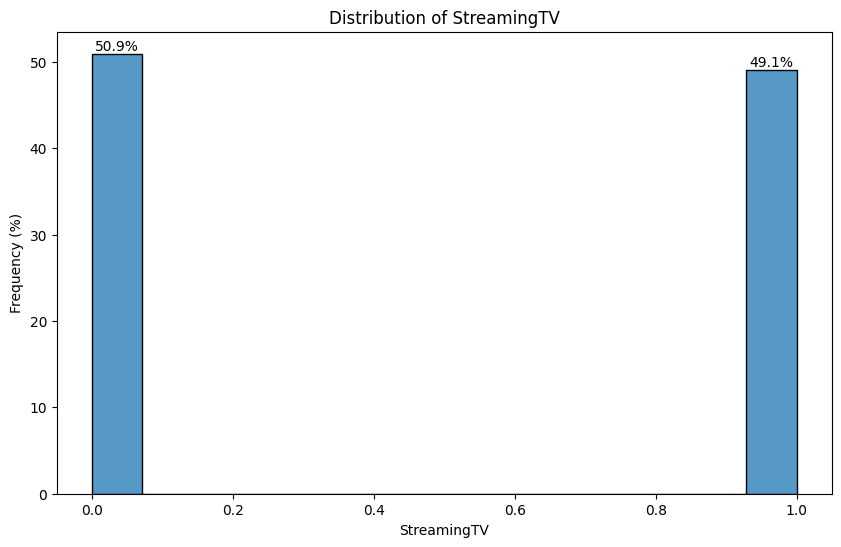

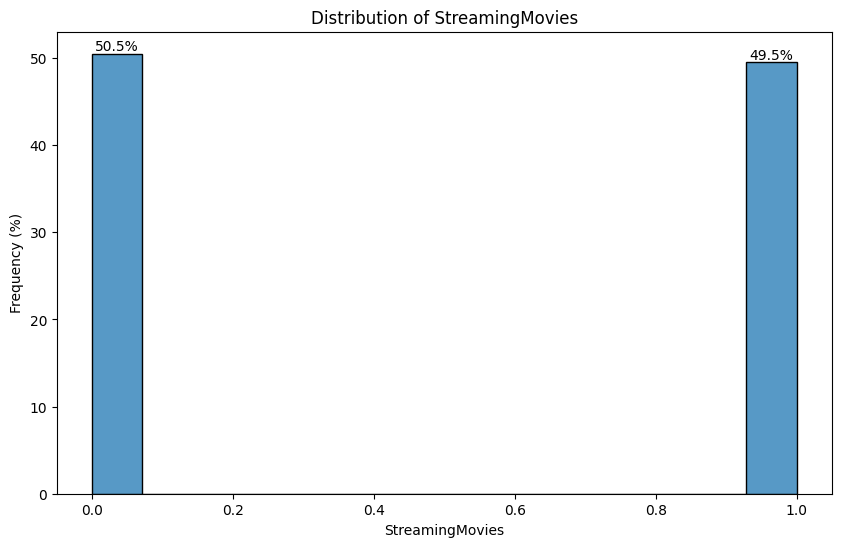

In [24]:
# specify the columns to plot
internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']  

# for each column in internet_cols, plot the distribution of the column
for col in internet_cols:
    plt.figure(figsize=(10, 6))
    
    # create the histogram
    ax = sns.histplot(x=col, data=internet, stat='percent')
    
    # Add percentage labels to each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only add labels to non-zero bars
            ax.annotate(f'{height:.1f}%', 
                        (p.get_x() + p.get_width() / 2, height), 
                        ha='center', va='bottom', fontsize=10)
            
    plt.title('Distribution of ' + col)
    plt.xlabel(col)
    plt.ylabel('Frequency (%)')
    plt.show()

- The internet dataset describes the products customers have as well as the internet service type (DSL or Fiber optic).
    - StreamingMovies, StreamingTV, OnlineBackup, and DeviceProtection are the most popluar products; respectively, 49.5%, 49.1%, 44.0%, and 43.9% of customers have these products.
    - TechSupport and OnlineSecurity are less popular; 37.0% and 36.6% of customers have these products, respectively.
    - 56.1% of customers have a fiber optic internet service type while 43.9% have DSL.


## Merge Dataframes for Analysis

In [25]:
# merge the DataFrames into one DataFrame using the CustomerID column
data = contract.merge(personal, on='CustomerID', how='left').merge(phone, on='CustomerID', how='left').merge(internet, on='CustomerID', how='left')

In [26]:
# get info about the merged DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 31 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   CustomerID                                      7032 non-null   object        
 1   BeginDate                                       7032 non-null   datetime64[ns]
 2   EndDate                                         1869 non-null   datetime64[ns]
 3   Type                                            7032 non-null   object        
 4   PaperlessBilling                                7032 non-null   int64         
 5   PaymentMethod                                   7032 non-null   object        
 6   MonthlyCharges                                  7032 non-null   float64       
 7   TotalCharges                                    7032 non-null   float64       
 8   EndDate_Binary                                  

## Engineer Features and Fill Missing Values

In [27]:
# create a feature for the number of internet products each customer has
data['InternetProducts_Count'] = data['OnlineSecurity'] + data['OnlineBackup'] + data['DeviceProtection'] + data['TechSupport'] + data['StreamingTV'] + data['StreamingMovies']

# fill the missing values in InternetProducts_Count with 0
data['InternetProducts_Count'] = data['InternetProducts_Count'].fillna(0)

# if multiple lines is not null and internet service is not null, create a new column indicating if the customer has both phone and internet service
data['Has_Phone_And_Internet'] = data.apply(lambda x: 1 if pd.notnull(x['MultipleLines']) and pd.notnull(x['InternetService']) else 0, axis=1)

# if customer has phone service, but not internet service, create a new column indicating if the customer has phone service only
data['Has_Phone_Only'] = data.apply(lambda x: 1 if pd.notnull(x['MultipleLines']) and pd.isnull(x['InternetService']) else 0, axis=1)

# if customer has internet service, but not phone service, create a new column indicating if the customer has internet service only
data['Has_Internet_Only'] = data.apply(lambda x: 1 if pd.isnull(x['MultipleLines']) and pd.notnull(x['InternetService']) else 0, axis=1)

# specify the binary columns that have missing values
binary_cols_with_na_values = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# fill the missing values in the binary columns with 0
for col in binary_cols_with_na_values:
    # fill missing values with 0
    data[col] = data[col].fillna(0)

# fill the missing values in MultipleLines with 0
data['MultipleLines'] = data['MultipleLines'].fillna(0)

# fill the missing values in InternetService with 'None'
data['InternetService'] = data['InternetService'].fillna('None')


## Create Dummy Variables for Categorical Features

In [28]:
# define the columns that are categorical
category_cols = ['Type', 'PaymentMethod', 'Gender', 'InternetService']

# create dummy variables for the categorical features
data = pd.get_dummies(data, columns=category_cols, drop_first=True)

## Explore the Relationships Between Features

In [29]:
# drop columns that are not needed (other features already encorporate the information)
data = data.drop(['BeginDate', 'EndDate', 'EndDate_Calc', 'CustomerID'], axis=1)

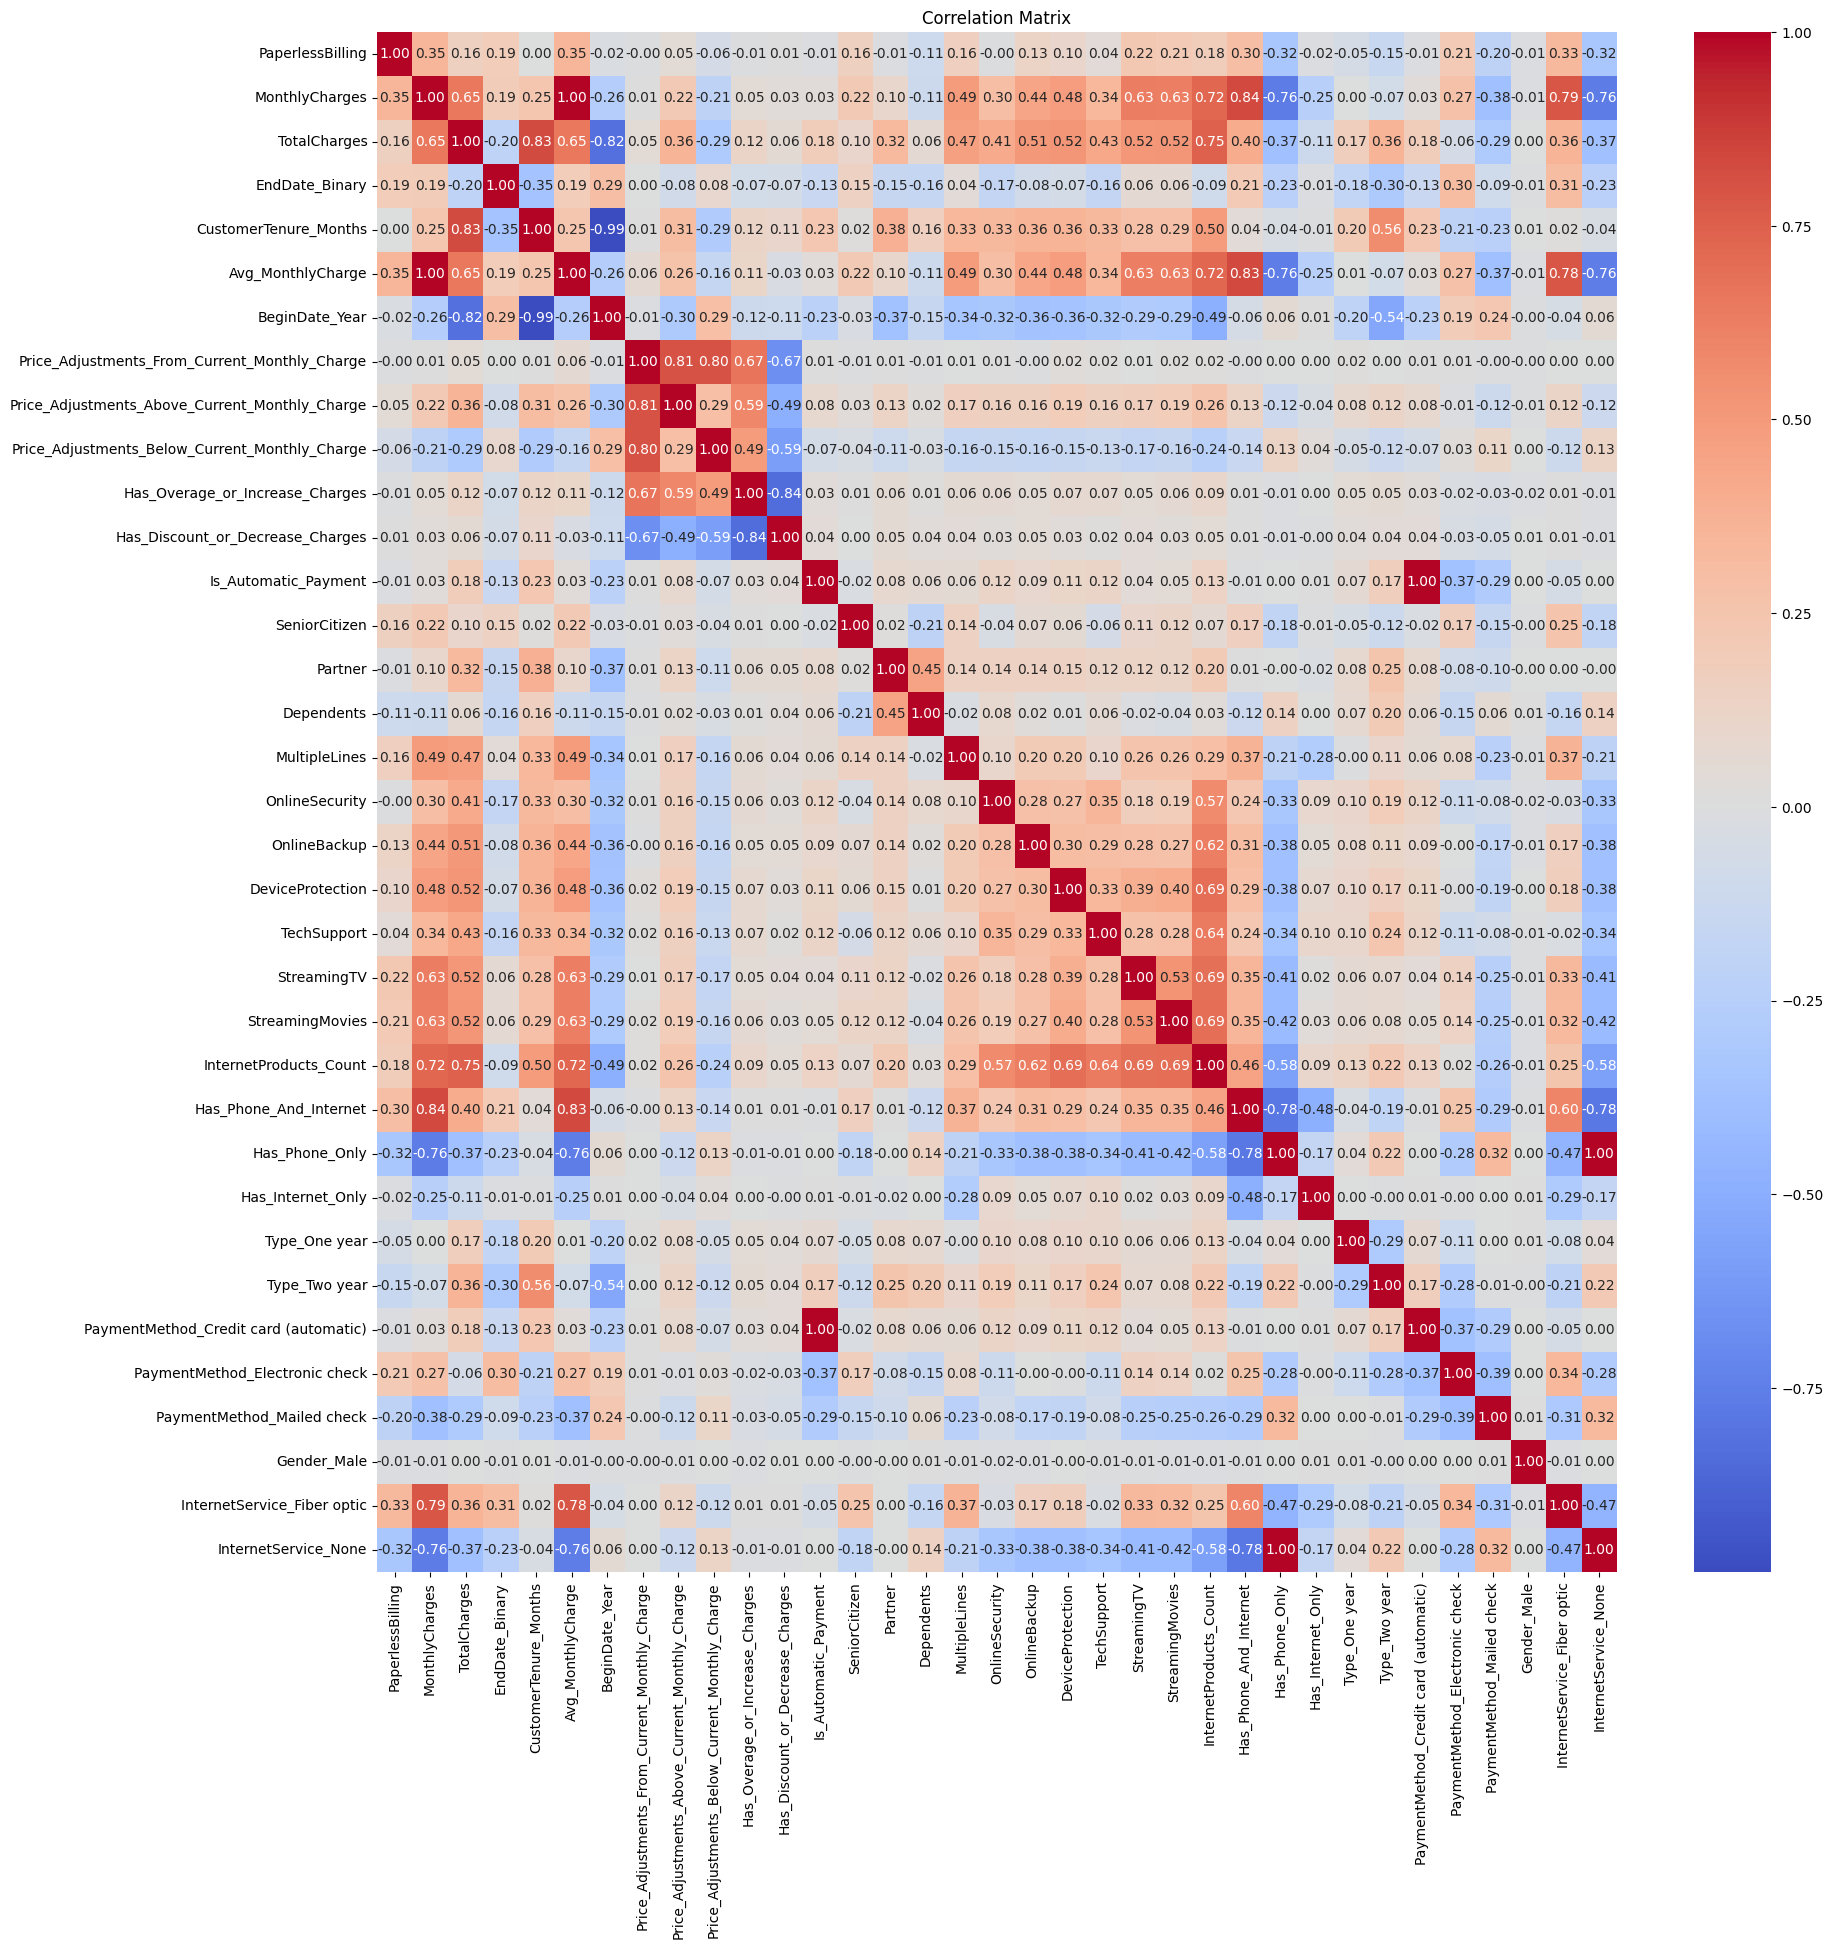

In [30]:
# plot the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

There are a lot of features combinations to observe in the correlation matrix heatmap. 

- The correlation between some combinations isn't very informative. 
    - For example, it's logical that customers that have both phone and internet service with Interconnect would have a strong negative correlation with customers that only have phone service with Interconnect.

However, there are some interestesting correlations of note:
- Customers churn less frequently when they…
	- have a discount or experienced a monthly charge price decrease (-0.35 correlation)
	- have internet service at all (-0.23 correlation)
	- have a two-year contract (-0.30 correlation)
	- have phone service only (-0.23 correlation)
	- have a higher count of internet-related products (-0.29 correlation)
	- have been an Interconnect customer for a longer period of time (-0.35 correlation)
	

- Customers churn more frequently when they…
	- have overage charges or experienced a monthly charge price increase (+0.40 correlation)
	- have Fiber optic Internet service (+0.31 correlation)
	- pay via electronic check (+0.30 correlation)
	- began their contract with Interconnect in more recent years (+0.29 correlation)
	- have higher monthly charges (+0.19 correlation)

These observations are helpful, but none of them have a very strong correlation with customer churn status on their own. The correlation values don't give us insight into how the individual features interact with one another to drive customer churn. 

Exploring the distribution of how our feature values by customer churn status can help shed some additional insight, but still won't capture the interactivity between features or the cause of customer churn well. Still, let's explore the relationship between the customer churn status and our non-binary numerical features a bit further.

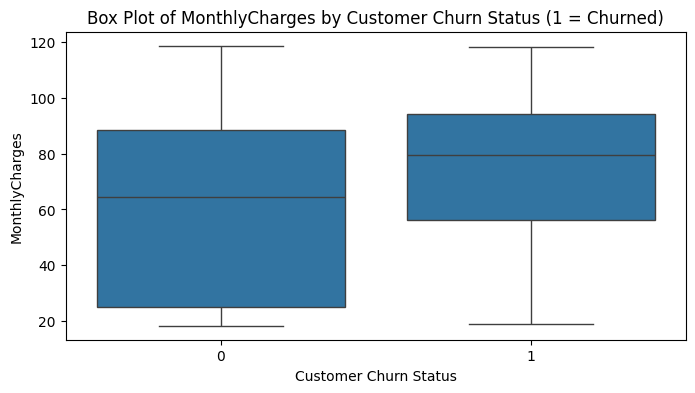

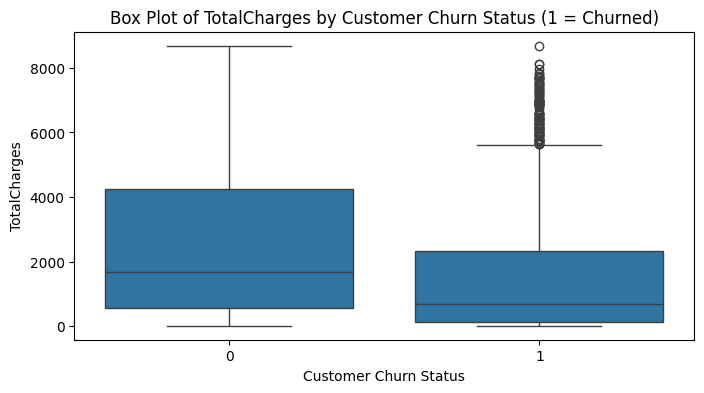

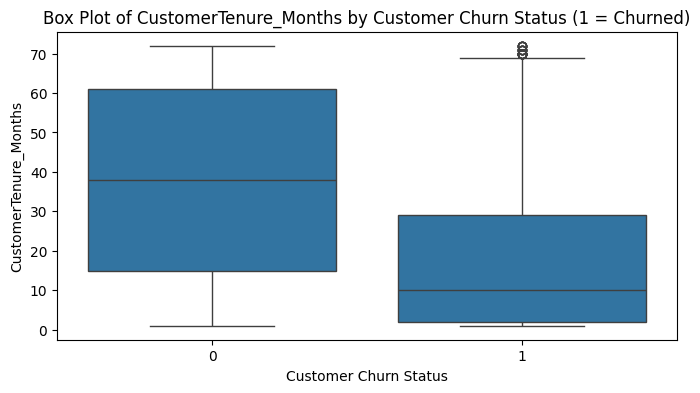

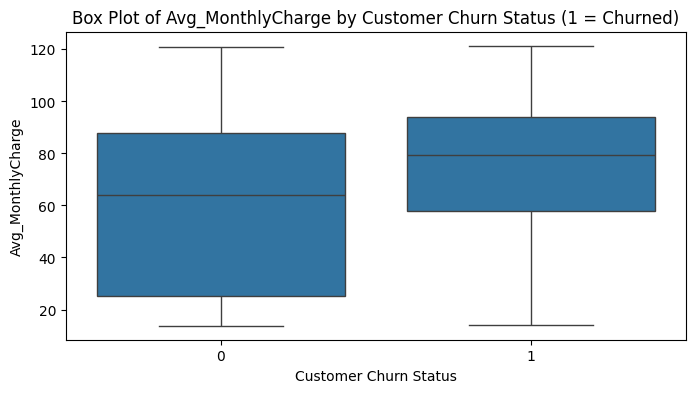

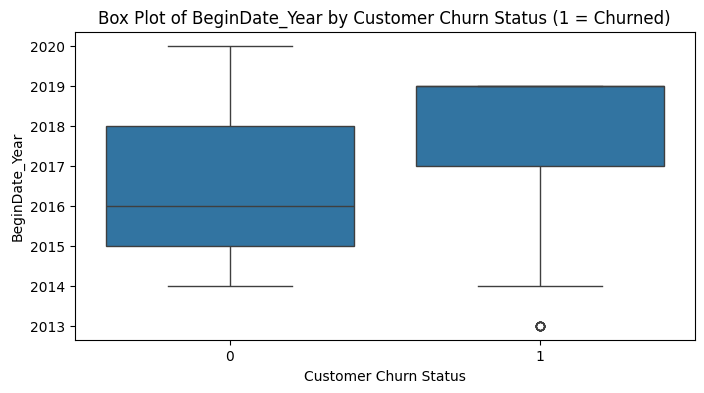

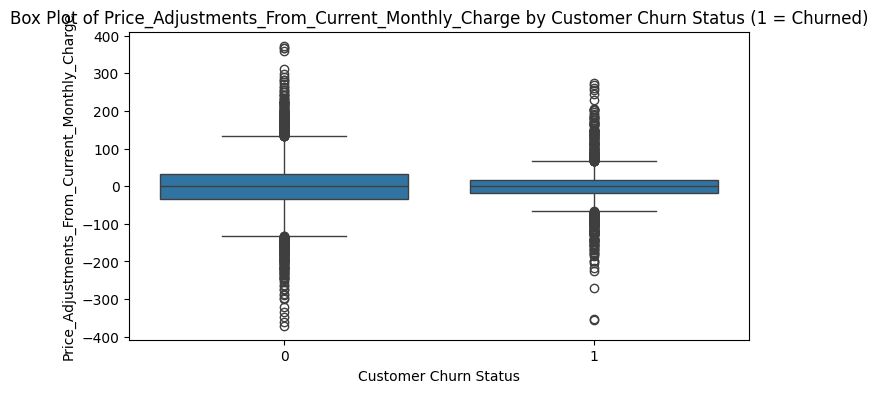

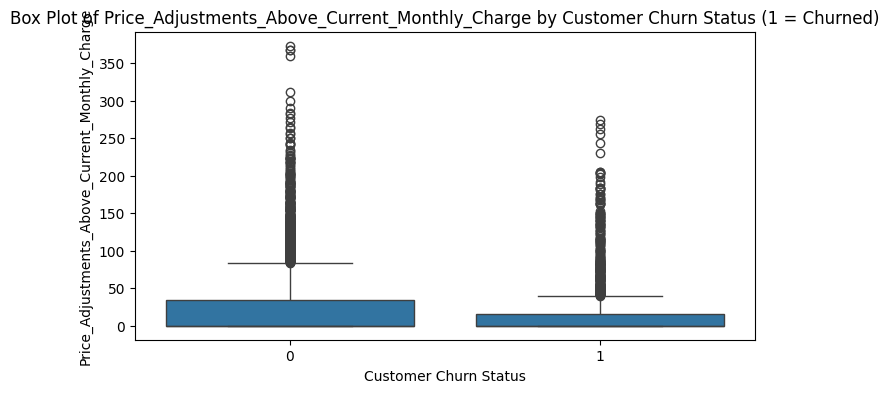

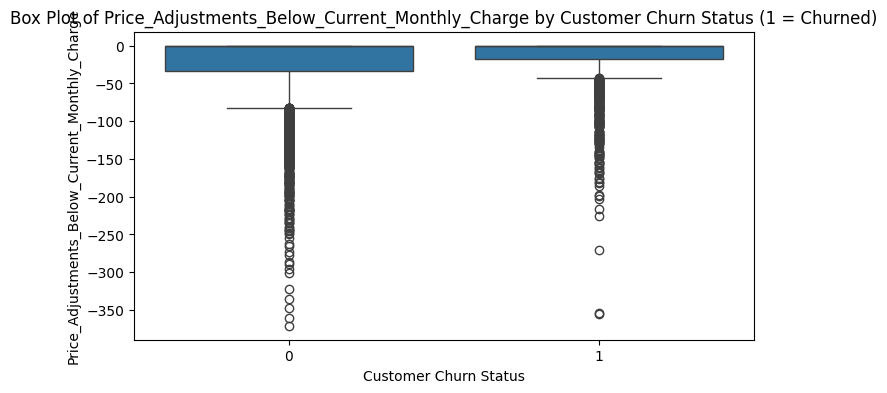

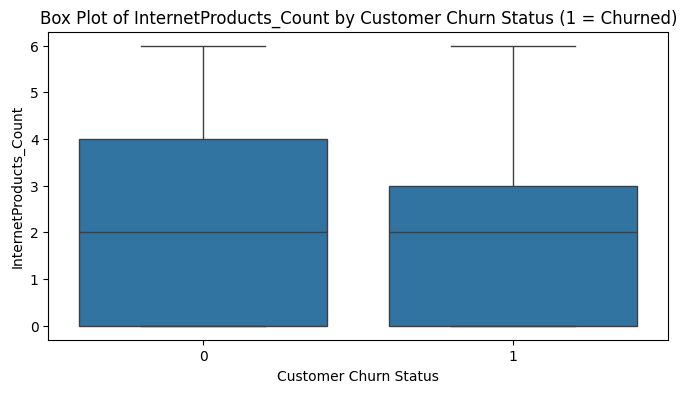

In [31]:
# plot a box plot of the non-binary features in data to understand how their distribution differ by EndDate_Binary
for col in data.columns:
    if col in ['MonthlyCharges', 'TotalCharges', 'BeginDate_Year', 'InternetProducts_Count', 
               'Price_Adjustments_From_Current_Monthly_Charge', 'Price_Adjustments_Above_Current_Monthly_Charge', 
               'Price_Adjustments_Below_Current_Monthly_Charge', 'Avg_MonthlyCharge', 'CustomerTenure_Months']:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='EndDate_Binary', y=col, data=data)
        plt.title('Box Plot of ' + col + ' by Customer Churn Status (1 = Churned)')
        plt.xlabel('Customer Churn Status')
        plt.ylabel(col)
        plt.show()



The box plots confirm what the correlation matrix initially revealed but add more insight.

- Compared to customers that haven't churned:
    - The median monthly charge of a churned customer is about $17 higher.
    - The median total charge of a churned customer is lower but there are a significant number of outliers that are even beyond the upper quartile of the non-churned customer values.
        - Perhaps customers churn due to unexpectedly high charges or fees that are beyond the scope of typical monthly charges.
    - A churned customer has a median tenure of about 10 months with Interconnect (vs. about 38 months for non-churned customers).
    - A churned customer has a median of 2 internet-related products vs. about 3 for a churned customer.

The distribution for the contract start year and price-adjusted realted columns align with our previous conclusions about how charges greater than or less than the expected total have changed over time--especially in 2019 and for month-to-month plan type customers.

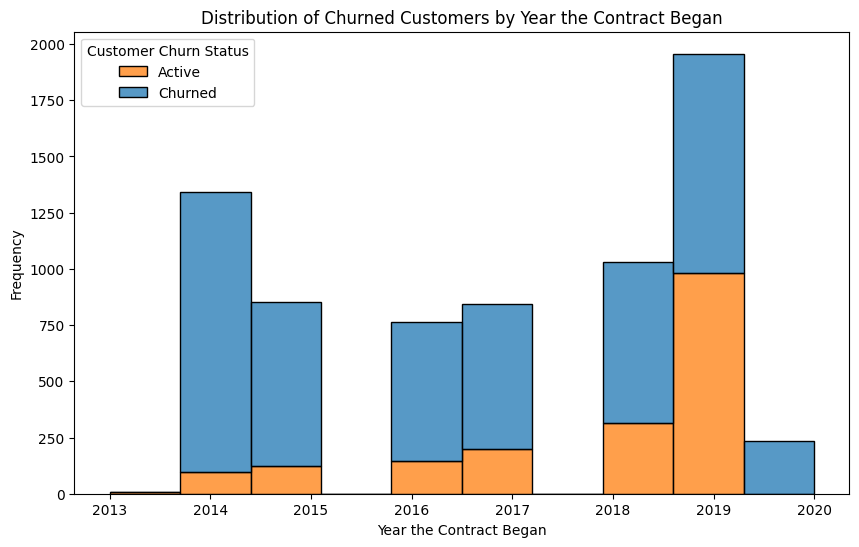

In [32]:
# plot the distribution of churned customers by BeginDate_Year
plt.figure(figsize=(10, 6))
sns.histplot(x='BeginDate_Year', data=data, hue='EndDate_Binary', bins=10, multiple='stack')
plt.title('Distribution of Churned Customers by Year the Contract Began')
plt.xlabel('Year the Contract Began')
plt.ylabel('Frequency')
plt.legend(title='Customer Churn Status', labels=['Active', 'Churned'])
plt.show()


More evidence--the % of customers that churn per Contract Start Year has been increasing over time, which can make sense when there are more customers overall regardless of churn status. However, the percent of churned customers is relatively and alarmingly high (around 50%) in 2019. 

These data points support the hypothesis that Interconnect made a big change to their product(s) or pricing over time or in 2019 specifically.

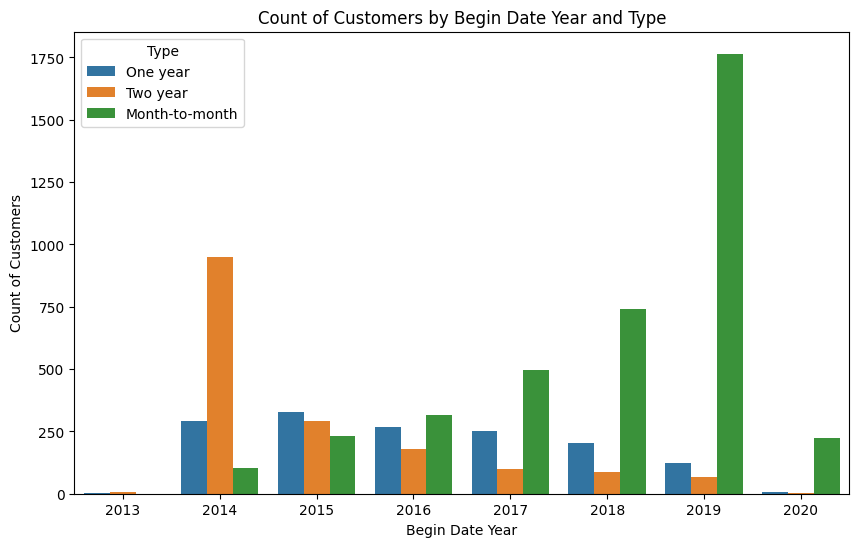

In [33]:
# group the data by BeginDate_Year and Type and count the number of customers
monthlychargebytype = contract.groupby(['BeginDate_Year', 'Type'])['CustomerID'].count().reset_index()

# plot the count of customers by begin date year, type value
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='BeginDate_Year', y='CustomerID', hue='Type', data=monthlychargebytype)
plt.title('Count of Customers by Begin Date Year and Type')
plt.xlabel('Begin Date Year')
plt.ylabel('Count of Customers')
plt.show()

The composition of customers by plan time has changed drastically by the contract start year. The number of customers on a month-to-month plan really took off in 2019. This change, in combination with any possible plan, pricing, or product offering changes, could have really huge impacts on customer churn.

## Clarifying Questions

We've achieved some helpful insight into factors that may influence customer churn, but will need to build a model to handle the complex interactivity of these factors and hence predict customer churn with accuracy.

The initial exploratory data analysis has raised some important questions that we should ask Interconnect for context:
- Does the dataset account for customers who may have ended a contract in the past but began a new one?
    - If so, is their data overwritten in the contract file?
    - Does the contract Type field only show the current or most recent type?
- Has the monthly rate of each plan type changed over time?
- Is each service/product charges on a flat rate or do customers incur charges based on product usage?
- Are customers offered an introductory rate or new customer discount which expires (turns into a higher rate) at a certain point in their contract?
    - If so, when do these introductory/new customer offers expire?
- Has the product offerings changed over time? What changed?
- Is Interconnect focused on predicting churn of any customer or just newer customers? Any more context on what they want to achieve with this model?


# Model Training and Validation

In [34]:
# import the necessary libraries for modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb


## Specify the Target and Features

In [35]:
# specify the target
target = data['EndDate_Binary']

# specify the features
features = data.drop('EndDate_Binary', axis=1)

## Split the Data into Training, Validation, and Testing Sets

In [36]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

# split the testing data into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## Scale the Features

In [37]:
# initialize the StandardScaler
scaler = StandardScaler()

# fit and transform the training data
X_train = scaler.fit_transform(X_train)

# transform the validation and testing data
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Define a Function To Get the AUC_ROC and Accuracy Scores for a Model

In [38]:
## define a Function To Get the AUC_ROC and Accuracy Scores for a Model
def get_model_scores(model, X_train, y_train, X_val, y_val):
    # fit the model
    model.fit(X_train, y_train)
    
    # get the predicted probabilities
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # get the predicted classes
    y_pred = model.predict(X_val)
    
    # get the AUC_ROC score
    auc_roc = roc_auc_score(y_val, y_pred_proba)
    
    # get the accuracy score
    accuracy = accuracy_score(y_val, y_pred)
    
    return print(f'Model: {model}, AUC-ROC Score: {auc_roc}, Accuracy Score: {accuracy}')


## Logistic Regression Model

In [39]:
# initialize the model
lr_model = LogisticRegression(random_state=12345, max_iter=1000, class_weight='balanced', solver='liblinear')

# get the AUC-ROC and accuracy scores for the validation set
print('Validation Set:')
get_model_scores(lr_model, X_train, y_train, X_val, y_val)


Validation Set:
Model: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12345,
                   solver='liblinear'), AUC-ROC Score: 0.8774749901208378, Accuracy Score: 0.7980085348506402


## Random Forest Classifier Model

In [40]:
# define the hyperparameters grid to search
param_grid = {
    'n_estimators': [50, 100, 200, 500], # number of trees in the forest
    'max_depth': [None, 10, 20, 30] # maximum depth of the tree
}

# initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=12345, class_weight='balanced')

# initialize the GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model, # the model to tune
    param_grid=param_grid, # the parameter grid to search
    cv=3, # 3-fold cross-validation
    verbose=2, # show progress of grid search
    scoring='roc_auc' # specify the score to optimize for
)

# fit the model with grid search
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=50; total time=   0.2s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.4s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.5s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.5s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=200; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=500; total time=   1.7s
[CV] END ...................max_depth=None, n_estimators=500; total time=   2.2s
[CV] END ...................max_depth=None, n_es

In [41]:
# train the model with the best parameters
rf_model = RandomForestClassifier(random_state=12345, n_estimators=500, max_depth=10, class_weight='balanced')
rf_model.fit(X_train, y_train)

# get the AUC-ROC and accuracy scores for the validation set
print('Validation Set:')
get_model_scores(rf_model, X_train, y_train, X_val, y_val)

Validation Set:
Model: RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=500,
                       random_state=12345), AUC-ROC Score: 0.858824171710239, Accuracy Score: 0.8079658605974396


## Decision Tree Classifier Model

In [42]:
# define the hyperparameters grid to search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20] # specify the maximum depth of the tree
}

# initialize the DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# initialize the GridSearchCV
grid_search = GridSearchCV(
    estimator=dt_model, # the model to tune
    param_grid=param_grid, # the parameter grid to search
    cv=3, # 3-fold cross-validation
    verbose=2, # show progress of grid search
    scoring='roc_auc' # specify the score to optimize for
)

# fit the model with grid search
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END .....................................max_depth=None; total time=   0.0s
[CV] END .....................................max_depth=None; total time=   0.0s
[CV] END .....................................max_depth=None; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=10; total time=   0.0s
[CV] END .......................................max_depth=15; total time=   0.0s
[CV] END .......................................max_depth=15; total time=   0.0s
[CV] END .......................................m

In [43]:
# train the model with the best parameters
dt_model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
dt_model.fit(X_train, y_train)

# get the AUC-ROC and accuracy scores for the validation set
print('Validation Set:')
get_model_scores(dt_model, X_train, y_train, X_val, y_val)

Validation Set:
Model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345), AUC-ROC Score: 0.8326716894407354, Accuracy Score: 0.783072546230441


## LightGBM

In [44]:
# define the param grid to search
param_grid = {
    'num_leaves': [15, 31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300],
    'boosting_type': ['gbdt'],  # gradient boosting decision tree
    'objective': ['binary'],  # binary classification
    'metric': ['auc'],  # AUC metric
    'max_depth': [-1, 10, 20, 30]
}

# initialize the LightGBM classifier
lgb_clf = lgb.LGBMClassifier(random_state=42, is_unbalance=True, objective='binary', boosting_type='gbdt')

# create the GridSearchCV object with scoring set to 'roc_auc'
grid_search = GridSearchCV(
    estimator=lgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',  #optimize for AUC-ROC
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # use all available cores
    verbose=2
)

# fit the model with grid search
grid_search.fit(X_train, y_train)

# print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation AUC-ROC Score: {grid_search.best_score_:.2f}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Info] Number of positive: 756, number of negative: 2056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.[LightGBM] [Info] Number of positive: 757, number of negative: 2056

[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 2812, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268848 -> initscore=-1.000476
[LightGBM] [Info] Start training from score -1.000476
[LightGBM] [Info] Number of positive: 757, number of negative: 2056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

In [45]:
# train the LightGBM classifier on the best parameters
lgb_clf = lgb.LGBMClassifier(random_state=42, boosting_type='gbdt', learning_rate=0.05, max_depth=-10, metric='auc', n_estimators=300, num_leaves=15, objective='binary', is_unbalance=True)

# train the model
lgb_clf.fit(X_train, y_train)

# get the AUC-ROC and accuracy scores for the validation set
print('Validation Set:')
get_model_scores(lgb_clf, X_train, y_train, X_val, y_val)

[LightGBM] [Info] Number of positive: 1135, number of negative: 3084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269021 -> initscore=-0.999595
[LightGBM] [Info] Start training from score -0.999595
Validation Set:
[LightGBM] [Info] Number of positive: 1135, number of negative: 3084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269021 -> initscore=-0.999595
[LightGBM] [Info] Start training from score -0.999595
Mo

### Best Model on Validation Set

Out of all the utilized models, the LightGBM Classifier model achieved the best AUC-ROC score on the validation set with a score of 0.88. The accuracy score was also good at 0.81%. Let's make sure the score is still satisfactory on the testing set.

### Testing Set AUC-ROC Score

In [46]:
# get the AUC-ROC and accuracy scores of the lightGBM model for the testing set
print('\nTesting Set:')
get_model_scores(lgb_clf, X_train, y_train, X_test, y_test)


Testing Set:
[LightGBM] [Info] Number of positive: 1135, number of negative: 3084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1695
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269021 -> initscore=-0.999595
[LightGBM] [Info] Start training from score -0.999595
Model: LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=-10,
               metric='auc', n_estimators=300, num_leaves=15,
               objective='binary', random_state=42), AUC-ROC Score: 0.8923524280314045, Accuracy Score: 0.8073916133617626


With an AUC-ROC score of 0.89 and an accuracy score of 0.80 on the testing set, the lightGBM model has achieved the highest assessment criteria tier for the project's performance! 

## Solution Report

- All steps of the plan (as described in the Project Process Overview section at the top of the notebook) were performed and none were skipped.

- The main difficulty of the project was understanding what the data in the contract dataset represented. I explored the data, made calculations, and checked individual examples to check the logic behind my assumptions. In a real business setting, we would confirm these assumptions with our colleagues and/or stakeholders and have the ability to collect more context about the dataset.

- Another challenge of the project was learning how to interpret the feature importance for the model and its business implications for Interconnect (covered in the next sections below). However, I really enjoyed learning about how to do this online!

-  Some of the key steps to solving the tasks were to engineer new features from the available data, account for class imbalance in the model training, and to hypertune the model parameters for optimal performance.
    - Spending sufficient time exploring the distribution of the data, cleaning the data, and better understanding the realtionships and correlations between the features (pre-existing and engineered) helped make the model training and selection process much easier. The quality and relevance of the features that the model is trained on really matters a lot.

- The final model was the LGBM Classifier model and it achieved a 0.89 AUC-ROC score on the testing set along with an accuracy score of 0.80.
    - LightGBM is a gradient boosting framework that uses tree based learning algorithms. We used a traditional gradient boosting decision tree boosting type.

## Feature Importance

The next steps will be to form conclusions about what the model results mean for Interconnect, how important certain features are in predicting customer churn, and what Interconnect can do to reduce feature churn.

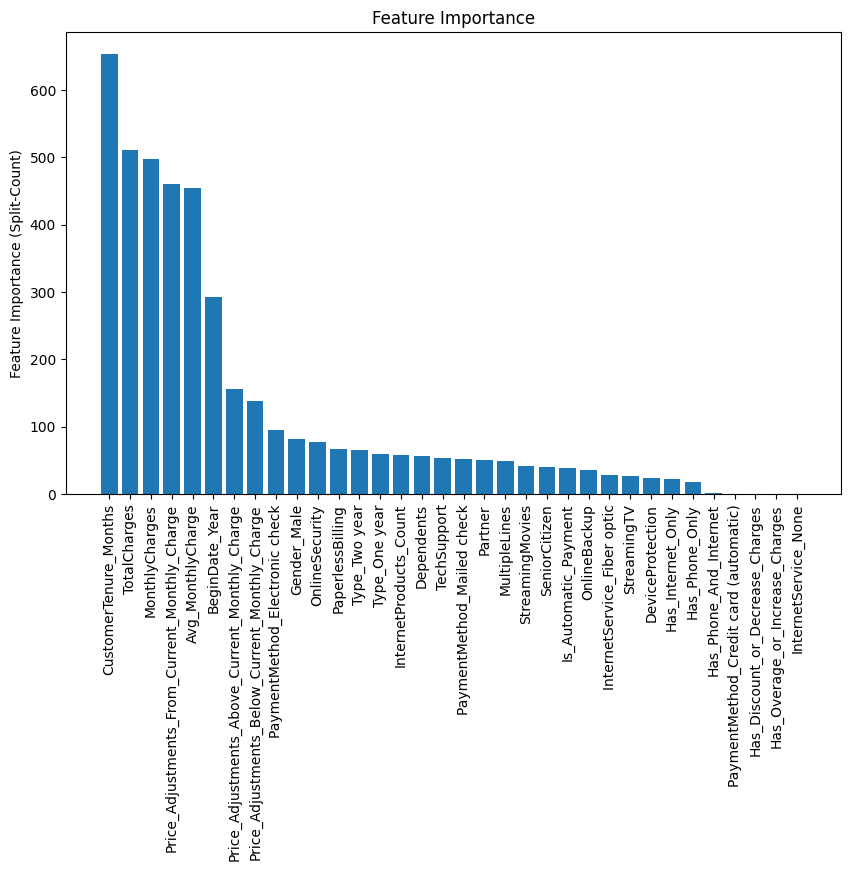

In [59]:
# get the feature importances from the lightGBM model
feature_importances = lgb_clf.feature_importances_

# specify the feature names
feature_names = features.columns

# sort feature importances
indices = np.argsort(feature_importances)[::-1]

# plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], rotation=90)
plt.ylabel('Feature Importance (Split-Count)')
plt.show()

Determining the feature importance by the decision tree split count (frequency) counts how many times each feature is used to make a split in the decision trees across the entire model. If a feature appears in many splits, it is considered more important because the model found it useful at different stages of the decision-making process.

A feature with high importance helps the model make better predictions for both positive and negative classes and not just for predicting the probability of the positive class.

/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


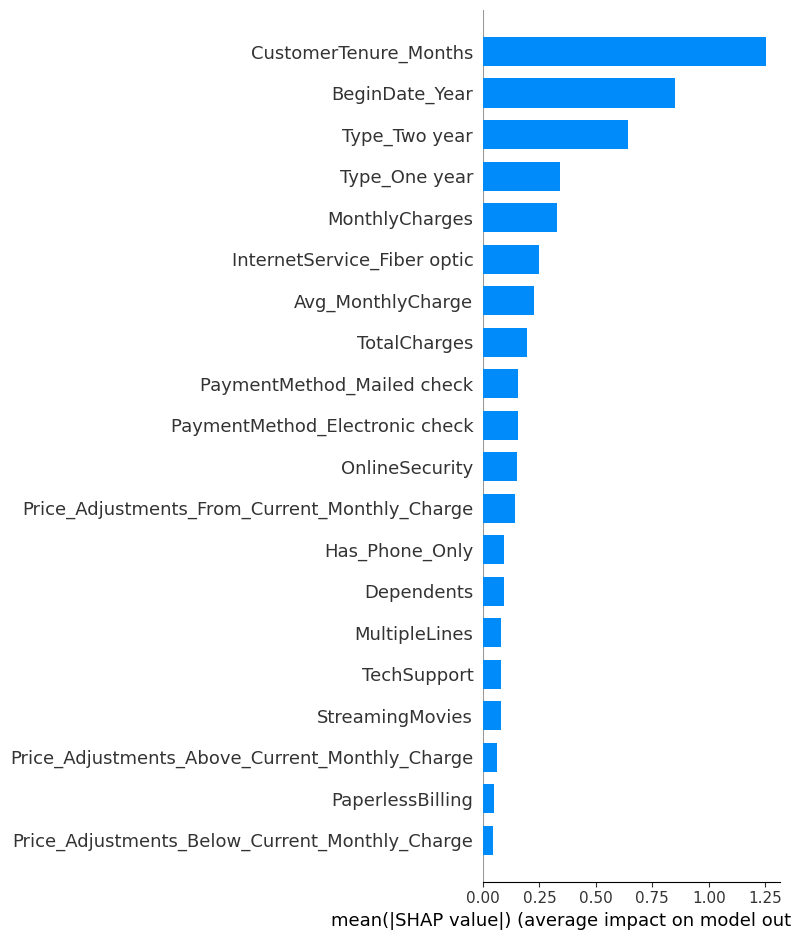

In [62]:
# import the necessary library to calculate SHAP values
import shap

# convert X_test to a DataFrame 
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# create a SHAP explainer using the trained LightGBM model
explainer = shap.TreeExplainer(lgb_clf)

# get SHAP values for the testing set
shap_values = explainer.shap_values(X_test_df)

# for binary classification, use shap_values[1] for the positive class
# if shap_values[1] is causing issues, use the original `shap_values` output directly.
if isinstance(shap_values, list):
   shap_values_to_plot = shap_values[1]  # Use for the positive class
else:
   shap_values_to_plot = shap_values

# create the SHAP summary plot for the positive class
shap.summary_plot(shap_values_to_plot, X_test_df, feature_names=feature_names, plot_type="bar")

The SHAP (SHapley Additive exPlanations) values represent how each feature contributes to a specific prediction made by the model. They help explain how each feature pushes the prediction away from the average or base prediction. 

By averaging SHAP values acrosss many predictions, the output helps us understand which features are generally most important within the entire dataset. 

For example, we can see that the customer tenure feature had the largest impact on the model's predictions. However, we still need to understand how the feature values impacted the likelihood of a positive class prediction (that a customer will churn).

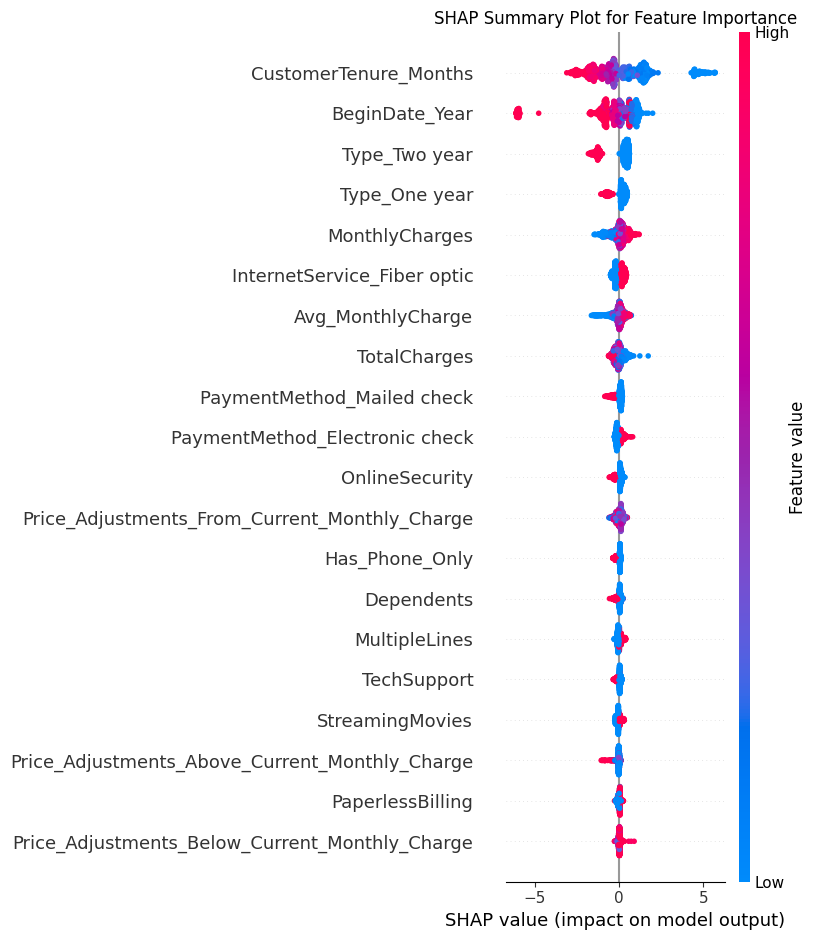

                                           Feature  Mean Absolute SHAP Value
3                            CustomerTenure_Months                  1.252908
5                                   BeginDate_Year                  0.849643
27                                   Type_Two year                  0.641266
26                                   Type_One year                  0.343350
1                                   MonthlyCharges                  0.326775
32                     InternetService_Fiber optic                  0.246637
4                                Avg_MonthlyCharge                  0.227260
2                                     TotalCharges                  0.197052
30                      PaymentMethod_Mailed check                  0.154568
29                  PaymentMethod_Electronic check                  0.154242
16                                  OnlineSecurity                  0.149213
6    Price_Adjustments_From_Current_Monthly_Charge                  0.140400

In [74]:
# create a summary plot for feature importance
plt.title('SHAP Summary Plot for Feature Importance')
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
# add title

mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)

# create a DataFrame for better readability
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Mean Absolute SHAP Value': mean_abs_shap_values
})

# sort by importance
feature_importance = feature_importance.sort_values(by='Mean Absolute SHAP Value', ascending=False)

# print the results
print(feature_importance)

# calculate the total sum of mean absolute SHAP values
total_mean_abs_shap = np.sum(mean_abs_shap_values)

# calculate the percentage contribution of each feature
importance_percentage = (mean_abs_shap_values / total_mean_abs_shap) * 100

# define a threshold for percentage contribution, e.g., 5%
important_features = feature_names[importance_percentage > 3]

print("\n\nImportant Features Based on SHAP Contribution (> 3%):")
print(important_features)

Now, we have a visual of how the relative values of each feature's predictions (represented by the color map in the graph) relate to SHAP scores on a negative to positive scale (x-axis values).

When considerating the importance of a dropped (reference) category as a result of one-hot encoding a catgorical feature, we can interpret the importance of the ommited category in the following way:
- If the SHAP values for the other categories within the categorical feature show consistent positive or negative effects, the baseline category likely has an opposite effect.
- Higher mean absolute SHAP values for the other categories in the categorical feature indirectly suggest that the feature as a while, including the dropped category, is important too.

Lastly, we can look at the percentage contribution of each feature's mean absolute SHAP value out of the total mean absolute SHAP values across all features to understand which ones have the most relative importance among the whole feature set.

The only features with over a 3% contribution (to the entire feature set's mean absolute SHAP values sum) are:
- Monthly Charges
- Customer Tenure (in months)
- Contract Start Year
- One Year Contract Type (Boolean)
- Two Year Contract Type (Boolean)
- Fiber Optic Internet Service (Boolean)

Thanks to our "SHAP Summary Plot for Feature Importance" chart, we can conclude that...
- The longer a customer has been an Interconnect customer, the less likely they are to churn.
- Customers with higher monthly charges are more likely to churn.
- Customers with a two year contract type are the least likely to churn followed by customers with a one year contract type.
    - Therefore, customers with a month-to-month contract type are more likely to churn.
- Customers with the fiber optic internet service are more likely to churn.

## Project Conclusion & Business Recommendation

The customer churn model project for Interconnect was a great example of how machine learning models can identify customers who are likely to churn with great accuracy, provide insight into factors that drive churn, and therefore also yield actionable insights that could help to reduce future/further customer churn.

Interconnect wants to offer promotional codes and special plan options to customers who are most likely to churn. Here are the most important recommendations Interconnect should implement to help reduce churn:
- Investigate customer dissatisfaction with fiber optic internet and try to fix or improve the problems with it. 
    - While this process is happening, offer customers on fiber optic internet promotions or entice them to switch to DSL internet instead.
- Give customers with month-to-month contracts promotions to get them to switch to one or two year contract types.
- Offer promotions to lower the monthly charges for newer and/or month-to-month contract customers. 
- Strucure monthly pricing in a way that minimizes the occurence of overage charges or price increases.
- Offer new or month-to-month contract type customers a promotional incentive to remain a customer for multiple subsequent months (further research is needed to understand a meaningful threshold in the relationship between customer tenure and churn status).
- Conduct customer outreach to new customers and month-to-month customers to better understand the areas of their service that they are happy or unhappy with for additional, actionable insights.
